In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For a nice progress bar!
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
def concat_csv():
    # Take the path of all the data
    # Read data
    df = pd.read_csv('/kaggle/input/datasolar/Data_Solar_cut.csv',header=0)
    df.set_index('DATE (MM/DD/YYYY)', inplace=True)
    df = df.fillna(method = 'ffill')
    return df

In [3]:
df = concat_csv()
print(df.info())  # Kiểm tra kiểu dữ liệu

/tmp/ipykernel_35/1504789278.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


<class 'pandas.core.frame.DataFrame'>
Index: 1742341 entries, 2015-01-01 00:00:00 to 2018-04-24 23:00:00
Data columns (total 26 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   Zenith Angle [degrees]                  float64
 1   Azimuth Angle [degrees]                 float64
 2   Airmass                                 float64
 3   Tower Dry Bulb Temp [deg C]             float64
 4   Tower Wet Bulb Temp [deg C]             float64
 5   Tower Dew Point Temp [deg C]            float64
 6   Tower Wind Chill Temp [deg C]           float64
 7   Tower RH [%]                            float64
 8   Total Cloud Cover [%]                   int64  
 9   Opaque Cloud Cover [%]                  int64  
 10  Avg Wind Speed @ 19ft [m/s]             float64
 11  Peak Wind Speed @ 19ft [m/s]            float64
 12  Avg Wind Direction @ 19ft [deg from N]  float64
 13  Vertical Wind Shear [1/s]               float64
 14  Station P

In [4]:
def correlation(dataset, threshold):
     col_corr = set()  # Set of all the names of correlated columns
     corr_matrix = dataset.corr(method='spearman')  # Calculate Spearman correlation
     num_columns = len(corr_matrix.columns)
     for i in range(num_columns):
         if i != 0:
             if abs(corr_matrix.iloc[i,25 ]) < threshold:
                 colname = corr_matrix.columns[i]
                 col_corr.add(colname)
     return col_corr
def get_loader(dataset,batch_size=16,shuffle=False):

    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=shuffle)
    return loader

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
def ordered_train_val_test_split(df, val_size, test_size):
    # Calculate the splitting indices
    val_index = int(len(df) * (1 - val_size - test_size))
    test_index = int(len(df) * (1 - test_size))

    # Split the DataFrame
    train_data = df.iloc[:val_index]
    val_data = df.iloc[val_index:test_index]
    test_data = df.iloc[test_index:]

    return train_data, val_data, test_data

In [5]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# class LSTM(nn.Module):
#      def __init__(self,input_size=8,hidden_size=256,num_layers=2,seq_length=12):
#          super(LSTM,self).__init__()
#          self.hidden_size = hidden_size
#          self.num_layers = num_layers
#          self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
#          self.fc = nn.Linear(hidden_size*seq_length,seq_length)
#      def forward(self,x):
#          out,(hidden,cell) = self.lstm(x)
#          # out: tensor of shape (batch_size, seq_length, hidden_size)

#          out = out.reshape(out.shape[0],-1)
#          # out: tensor of shape (batch_size, seq_length * hidden_size)

#          out = self.fc(out)
#          # out: shape (batch_size,seq_length)
#          return out

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class RNN(nn.Module):
    def __init__(self,input_size=8,hidden_size=256,num_layers=2,seq_length=12):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.RNN(input_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size*seq_length,seq_length)
    def forward(self,x):
        out,_ = self.lstm(x)
        # out: tensor of shape (batch_size, seq_length, hidden_size)

        out = out.reshape(out.shape[0],-1)
        # out: tensor of shape (batch_size, seq_length * hidden_size)

        out = self.fc(out)
        # out: shape (batch_size,seq_length)
        return out

In [7]:
class Irradiation_Dataset(Dataset):
    def __init__(self,data,target,trainop1=True):
        self.data = data # shape [num_samples,num_feature]
        self.target = target # shape [num_samples,1]
        self.trainop1 = trainop1
    def __len__(self):
        if self.trainop1:
            return self.data.shape[0]//24-1
        else:
            return self.data.shape[0]//24

    def __getitem__(self,index):
        if self.trainop1:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = (index+1)*seq_length
            targets_end_idx = targets_start_idx+24
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]

            return torch.tensor(features),torch.tensor(targets)
        else:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = index * seq_length
            targets_end_idx = (index+1)*seq_length
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]
        return torch.tensor(features),torch.tensor(targets)

In [8]:
df = df.iloc[:, [0, 2, 3, 7, 9, 12, 23, 25]]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1742341 entries, 2015-01-01 00:00:00 to 2018-04-24 23:00:00
Data columns (total 8 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   Zenith Angle [degrees]                  float64
 1   Airmass                                 float64
 2   Tower Dry Bulb Temp [deg C]             float64
 3   Tower RH [%]                            float64
 4   Opaque Cloud Cover [%]                  int64  
 5   Avg Wind Direction @ 19ft [deg from N]  float64
 6   Global Extraterrestrial (calc) [W/m^2]  float64
 7   GHI Mean                                float64
dtypes: float64(7), int64(1)
memory usage: 119.6+ MB
None


In [9]:
target_column = 'GHI Mean'
trainop1 = True

X = df
Y = df[target_column]
Y = pd.DataFrame({target_column: Y})

X_train, X_val, X_test = ordered_train_val_test_split(X,0.1,0.1)
Y_train, Y_val, Y_test = ordered_train_val_test_split(Y,0.1,0.1)

if not trainop1:
    X_train = X_train.drop(target_column,axis=1)
    X_val = X_val.drop(target_column,axis=1)
    X_test = X_test.drop(target_column,axis=1)

In [10]:
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns).values
X_val = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns).values
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns).values


Y_scaler = StandardScaler()
Y_train = pd.DataFrame(Y_scaler.fit_transform(Y_train), columns=Y_train.columns).values
Y_val = pd.DataFrame(Y_scaler.transform(Y_val), columns=Y_val.columns).values
Y_test = pd.DataFrame(Y_scaler.transform(Y_test), columns=Y_test.columns).values

# print(Y_test)

In [11]:
print("The shape of the original data:",df.shape)
print("The shape of the train data:",X_train.shape)
print("The shape of the train target:",Y_train.shape)
print("The shape of the val data:",X_val.shape)
print("The shape of the val target:",Y_val.shape)
print("The shape of the test data:",X_test.shape)
print("The shape of the test target:",Y_test.shape)

train_data = Irradiation_Dataset(X_train,Y_train,trainop1=trainop1)
val_data = Irradiation_Dataset(X_val,Y_val,trainop1=trainop1)
test_data = Irradiation_Dataset(X_test,Y_test,trainop1=trainop1)

print(len(train_data))
print(len(val_data))
print(len(test_data))

train_data_loader = get_loader(train_data)
val_data_loader = get_loader(val_data)
test_data_loader = get_loader(test_data)

The shape of the original data: (1742341, 8)
The shape of the train data: (1393872, 8)
The shape of the train target: (1393872, 1)
The shape of the val data: (174234, 8)
The shape of the val target: (174234, 1)
The shape of the test data: (174235, 8)
The shape of the test target: (174235, 1)
58077
7258
7258


In [12]:
input_size = df.shape[1]
print(input_size)

8


In [13]:
#HYPERPARAMETERS
input_size = 8
hidden_size = 64
num_layers = 2
sequence_length = 24
learning_rate = 0.001
batch_size = 16
num_epochs = 300
min_valid_loss = np.inf

In [14]:
# MODEL
model = RNN(input_size=input_size,
             hidden_size=hidden_size,
             num_layers=num_layers,
             seq_length=sequence_length).to(device=device)

# randn_tensor = torch.randn((16,12,10))
# x = model(randn_tensor)
# x.shape

In [15]:
#LOSS AND OPTIMIZER
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer,
                                        start_factor=1.0,
                                        end_factor=0.01)

In [16]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        """
        patience: số epoch chờ đợi sau khi validation loss không giảm
        min_delta: mức giảm tối thiểu của validation loss để coi là cải thiện
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # reset counter nếu cải thiện
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


In [17]:
early_stopping = EarlyStopping(patience=20, min_delta=1e-5)  # Bạn có thể điều chỉnh
#TRAIN THE MODEL
for epoch in range(num_epochs):
    print("Epoch: ",epoch)
    train_loss = 0
    model.train()
    for batch_idx,(data,target) in enumerate(tqdm(train_data_loader)):
        data = data.to(device=device,dtype=torch.float)
        target = target.to(device=device,dtype=torch.float).squeeze(2)

        scores = model(data)
        loss = criterion(scores,target)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        train_loss += loss.item()
    scheduler.step()
    avg_train_loss = train_loss / len(train_data_loader)
    print("Train Loss:", avg_train_loss)
    valid_loss = 0

    model.eval()
    with torch.no_grad():
        total_scores_val = None
        total_target_val = None
        for batch_idx_val,(data_val,target_val) in enumerate(tqdm(val_data_loader)):
            data_val = data_val.to(device=device,dtype=torch.float)
            target_val = target_val.to(device=device,dtype=torch.float).squeeze(2)

            scores_val = model(data_val)
            loss_val = criterion(scores_val,target_val)

            valid_loss += loss_val.item()
    avg_valid_loss = valid_loss / len(val_data_loader)
    print("Validation Loss:", avg_valid_loss)

    if min_valid_loss > valid_loss/len(val_data_loader):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(valid_loss/len(val_data_loader)):.6f} \t Saving The Model')
        min_valid_loss = valid_loss/len(val_data_loader)
        # Saving State Dict
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint)
        torch.save(model, "model_predict_.pth.tar")

     # Kiểm tra EarlyStopping
    early_stopping(avg_valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch:  0


100%|██████████| 3630/3630 [00:10<00:00, 356.11it/s]


Train Loss: 0.10365483253944131


100%|██████████| 454/454 [00:00<00:00, 1091.86it/s]


Validation Loss: 0.08892354303429884
Validation Loss Decreased(inf--->0.088924 	 Saving The Model
=> Saving checkpoint
Epoch:  1


100%|██████████| 3630/3630 [00:09<00:00, 364.22it/s]


Train Loss: 0.0912295161563


100%|██████████| 454/454 [00:00<00:00, 1021.52it/s]


Validation Loss: 0.053144446161954094
Validation Loss Decreased(0.088924--->0.053144 	 Saving The Model
=> Saving checkpoint
Epoch:  2


100%|██████████| 3630/3630 [00:09<00:00, 373.98it/s]


Train Loss: 0.08627408983215212


100%|██████████| 454/454 [00:00<00:00, 1069.59it/s]


Validation Loss: 0.04483268751469461
Validation Loss Decreased(0.053144--->0.044833 	 Saving The Model
=> Saving checkpoint
Epoch:  3


100%|██████████| 3630/3630 [00:09<00:00, 367.08it/s]


Train Loss: 0.08278908404947448


100%|██████████| 454/454 [00:00<00:00, 1023.14it/s]


Validation Loss: 0.03946839205947364
Validation Loss Decreased(0.044833--->0.039468 	 Saving The Model
=> Saving checkpoint
Epoch:  4


100%|██████████| 3630/3630 [00:10<00:00, 359.43it/s]


Train Loss: 0.0802721013957917


100%|██████████| 454/454 [00:00<00:00, 672.39it/s] 


Validation Loss: 0.03667823379147887
Validation Loss Decreased(0.039468--->0.036678 	 Saving The Model
=> Saving checkpoint
Epoch:  5


100%|██████████| 3630/3630 [00:10<00:00, 360.17it/s]


Train Loss: 0.07872478044581496


100%|██████████| 454/454 [00:00<00:00, 1054.34it/s]


Validation Loss: 0.035577757074228396
Validation Loss Decreased(0.036678--->0.035578 	 Saving The Model
=> Saving checkpoint
Epoch:  6


100%|██████████| 3630/3630 [00:09<00:00, 369.24it/s]


Train Loss: 0.07835104546893515


100%|██████████| 454/454 [00:00<00:00, 1064.23it/s]


Validation Loss: 0.035487410797953284
Validation Loss Decreased(0.035578--->0.035487 	 Saving The Model
=> Saving checkpoint
Epoch:  7


100%|██████████| 3630/3630 [00:10<00:00, 355.19it/s]


Train Loss: 0.07819824458043768


100%|██████████| 454/454 [00:00<00:00, 998.61it/s] 


Validation Loss: 0.03546957842092428
Validation Loss Decreased(0.035487--->0.035470 	 Saving The Model
=> Saving checkpoint
Epoch:  8


100%|██████████| 3630/3630 [00:09<00:00, 368.11it/s]


Train Loss: 0.07809694780182787


100%|██████████| 454/454 [00:00<00:00, 1044.61it/s]


Validation Loss: 0.03546287376279566
Validation Loss Decreased(0.035470--->0.035463 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  9


100%|██████████| 3630/3630 [00:10<00:00, 362.98it/s]


Train Loss: 0.07801711984631776


100%|██████████| 454/454 [00:00<00:00, 1053.16it/s]


Validation Loss: 0.03545916418792459
Validation Loss Decreased(0.035463--->0.035459 	 Saving The Model
=> Saving checkpoint
Epoch:  10


100%|██████████| 3630/3630 [00:10<00:00, 360.38it/s]


Train Loss: 0.07794904428731322


100%|██████████| 454/454 [00:00<00:00, 1010.79it/s]


Validation Loss: 0.03545641150242969
Validation Loss Decreased(0.035459--->0.035456 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  11


100%|██████████| 3630/3630 [00:10<00:00, 353.18it/s]


Train Loss: 0.07788838933635212


100%|██████████| 454/454 [00:00<00:00, 1019.47it/s]


Validation Loss: 0.035453719282382244
Validation Loss Decreased(0.035456--->0.035454 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  12


100%|██████████| 3630/3630 [00:10<00:00, 358.70it/s]


Train Loss: 0.07783293819758118


100%|██████████| 454/454 [00:00<00:00, 1042.85it/s]


Validation Loss: 0.035450709022370575
Validation Loss Decreased(0.035454--->0.035451 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  13


100%|██████████| 3630/3630 [00:10<00:00, 362.16it/s]


Train Loss: 0.07778135166550687


100%|██████████| 454/454 [00:00<00:00, 1001.25it/s]


Validation Loss: 0.03544712089740738
Validation Loss Decreased(0.035451--->0.035447 	 Saving The Model
=> Saving checkpoint
Epoch:  14


100%|██████████| 3630/3630 [00:09<00:00, 365.20it/s]


Train Loss: 0.07773271777981497


100%|██████████| 454/454 [00:00<00:00, 1034.40it/s]


Validation Loss: 0.03544287711852702
Validation Loss Decreased(0.035447--->0.035443 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  15


100%|██████████| 3630/3630 [00:09<00:00, 365.65it/s]


Train Loss: 0.07768656115373927


100%|██████████| 454/454 [00:00<00:00, 1062.36it/s]


Validation Loss: 0.03543801301237878
Validation Loss Decreased(0.035443--->0.035438 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  16


100%|██████████| 3630/3630 [00:09<00:00, 365.70it/s]


Train Loss: 0.07764246438816055


100%|██████████| 454/454 [00:00<00:00, 1038.57it/s]


Validation Loss: 0.035432558915807516
Validation Loss Decreased(0.035438--->0.035433 	 Saving The Model
=> Saving checkpoint
Epoch:  17


100%|██████████| 3630/3630 [00:09<00:00, 368.56it/s]


Train Loss: 0.0776001350994189


100%|██████████| 454/454 [00:00<00:00, 1073.41it/s]


Validation Loss: 0.035426620874128546
Validation Loss Decreased(0.035433--->0.035427 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  18


100%|██████████| 3630/3630 [00:09<00:00, 371.90it/s]


Train Loss: 0.0775593745125352


100%|██████████| 454/454 [00:00<00:00, 1057.28it/s]


Validation Loss: 0.03542024472390761
Validation Loss Decreased(0.035427--->0.035420 	 Saving The Model
=> Saving checkpoint
Epoch:  19


100%|██████████| 3630/3630 [00:09<00:00, 371.09it/s]


Train Loss: 0.07752002162121266


100%|██████████| 454/454 [00:00<00:00, 1068.01it/s]


Validation Loss: 0.035413485215808234
Validation Loss Decreased(0.035420--->0.035413 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  20


100%|██████████| 3630/3630 [00:09<00:00, 368.20it/s]


Train Loss: 0.0774819411458475


100%|██████████| 454/454 [00:00<00:00, 1071.33it/s]


Validation Loss: 0.0354064109037348
Validation Loss Decreased(0.035413--->0.035406 	 Saving The Model
=> Saving checkpoint
Epoch:  21


100%|██████████| 3630/3630 [00:09<00:00, 367.81it/s]


Train Loss: 0.07744501016632997


100%|██████████| 454/454 [00:00<00:00, 1067.66it/s]


Validation Loss: 0.03539913949506855
Validation Loss Decreased(0.035406--->0.035399 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  22


100%|██████████| 3630/3630 [00:09<00:00, 372.95it/s]


Train Loss: 0.07740912138907376


100%|██████████| 454/454 [00:00<00:00, 1083.28it/s]


Validation Loss: 0.03539168004136118
Validation Loss Decreased(0.035399--->0.035392 	 Saving The Model
=> Saving checkpoint
Epoch:  23


100%|██████████| 3630/3630 [00:09<00:00, 366.12it/s]


Train Loss: 0.0773741975468334


100%|██████████| 454/454 [00:00<00:00, 1072.51it/s]


Validation Loss: 0.035384053215803894
Validation Loss Decreased(0.035392--->0.035384 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  24


100%|██████████| 3630/3630 [00:09<00:00, 370.59it/s]


Train Loss: 0.07734016625971672


100%|██████████| 454/454 [00:00<00:00, 1012.57it/s]


Validation Loss: 0.03537632260677649
Validation Loss Decreased(0.035384--->0.035376 	 Saving The Model
=> Saving checkpoint
Epoch:  25


100%|██████████| 3630/3630 [00:09<00:00, 375.47it/s]


Train Loss: 0.07730695891111793


100%|██████████| 454/454 [00:00<00:00, 1003.70it/s]


Validation Loss: 0.03536852488202028
Validation Loss Decreased(0.035376--->0.035369 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  26


100%|██████████| 3630/3630 [00:09<00:00, 369.40it/s]


Train Loss: 0.07727451920088002


100%|██████████| 454/454 [00:00<00:00, 1049.31it/s]


Validation Loss: 0.0353607335935257
Validation Loss Decreased(0.035369--->0.035361 	 Saving The Model
=> Saving checkpoint
Epoch:  27


100%|██████████| 3630/3630 [00:09<00:00, 371.67it/s]


Train Loss: 0.07724281539450321


100%|██████████| 454/454 [00:00<00:00, 1081.06it/s]


Validation Loss: 0.03535295029767055
Validation Loss Decreased(0.035361--->0.035353 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  28


100%|██████████| 3630/3630 [00:09<00:00, 372.41it/s]


Train Loss: 0.07721179709865583


100%|██████████| 454/454 [00:00<00:00, 1072.68it/s]


Validation Loss: 0.03534517681483453
Validation Loss Decreased(0.035353--->0.035345 	 Saving The Model
=> Saving checkpoint
Epoch:  29


100%|██████████| 3630/3630 [00:09<00:00, 366.31it/s]


Train Loss: 0.0771814244631905


100%|██████████| 454/454 [00:00<00:00, 1055.64it/s]


Validation Loss: 0.03533742686822293
Validation Loss Decreased(0.035345--->0.035337 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  30


100%|██████████| 3630/3630 [00:09<00:00, 370.62it/s]


Train Loss: 0.07715167791117451


100%|██████████| 454/454 [00:00<00:00, 1041.24it/s]


Validation Loss: 0.03532970692297283
Validation Loss Decreased(0.035337--->0.035330 	 Saving The Model
=> Saving checkpoint
Epoch:  31


100%|██████████| 3630/3630 [00:09<00:00, 371.60it/s]


Train Loss: 0.07712252807112263


100%|██████████| 454/454 [00:00<00:00, 1082.04it/s]


Validation Loss: 0.03532203337294258
Validation Loss Decreased(0.035330--->0.035322 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  32


100%|██████████| 3630/3630 [00:09<00:00, 367.60it/s]


Train Loss: 0.07709392520150185


100%|██████████| 454/454 [00:00<00:00, 1027.59it/s]


Validation Loss: 0.03531441171914878
Validation Loss Decreased(0.035322--->0.035314 	 Saving The Model
=> Saving checkpoint
Epoch:  33


100%|██████████| 3630/3630 [00:09<00:00, 369.94it/s]


Train Loss: 0.07706581326372232


100%|██████████| 454/454 [00:00<00:00, 1047.20it/s]


Validation Loss: 0.03530684693283338
Validation Loss Decreased(0.035314--->0.035307 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  34


100%|██████████| 3630/3630 [00:09<00:00, 371.65it/s]


Train Loss: 0.0770381949270578


100%|██████████| 454/454 [00:00<00:00, 1073.77it/s]


Validation Loss: 0.03529930688912102
Validation Loss Decreased(0.035307--->0.035299 	 Saving The Model
=> Saving checkpoint
Epoch:  35


100%|██████████| 3630/3630 [00:09<00:00, 368.56it/s]


Train Loss: 0.07701105267300334


100%|██████████| 454/454 [00:00<00:00, 1058.88it/s]


Validation Loss: 0.03529180403895409
Validation Loss Decreased(0.035299--->0.035292 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  36


100%|██████████| 3630/3630 [00:09<00:00, 375.06it/s]


Train Loss: 0.07698435830567671


100%|██████████| 454/454 [00:00<00:00, 1075.23it/s]


Validation Loss: 0.03528433880104072
Validation Loss Decreased(0.035292--->0.035284 	 Saving The Model
=> Saving checkpoint
Epoch:  37


100%|██████████| 3630/3630 [00:09<00:00, 372.50it/s]


Train Loss: 0.07695808601531447


100%|██████████| 454/454 [00:00<00:00, 1049.73it/s]


Validation Loss: 0.035276914984741364
Validation Loss Decreased(0.035284--->0.035277 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  38


100%|██████████| 3630/3630 [00:09<00:00, 365.81it/s]


Train Loss: 0.07693219935916232


100%|██████████| 454/454 [00:00<00:00, 1053.68it/s]


Validation Loss: 0.03526953744219825
Validation Loss Decreased(0.035277--->0.035270 	 Saving The Model
=> Saving checkpoint
Epoch:  39


100%|██████████| 3630/3630 [00:09<00:00, 371.01it/s]


Train Loss: 0.07690667273862649


100%|██████████| 454/454 [00:00<00:00, 1073.50it/s]


Validation Loss: 0.03526219882297134
Validation Loss Decreased(0.035270--->0.035262 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  40


100%|██████████| 3630/3630 [00:10<00:00, 356.52it/s]


Train Loss: 0.07688151208937119


100%|██████████| 454/454 [00:00<00:00, 1027.07it/s]


Validation Loss: 0.03525485015657649
Validation Loss Decreased(0.035262--->0.035255 	 Saving The Model
=> Saving checkpoint
Epoch:  41


100%|██████████| 3630/3630 [00:10<00:00, 354.72it/s]


Train Loss: 0.07685668289765384


100%|██████████| 454/454 [00:00<00:00, 1001.85it/s]


Validation Loss: 0.03524752446895793
Validation Loss Decreased(0.035255--->0.035248 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  42


100%|██████████| 3630/3630 [00:09<00:00, 364.93it/s]


Train Loss: 0.07683216708070219


100%|██████████| 454/454 [00:00<00:00, 1049.46it/s]


Validation Loss: 0.035240218055086654
Validation Loss Decreased(0.035248--->0.035240 	 Saving The Model
=> Saving checkpoint
Epoch:  43


100%|██████████| 3630/3630 [00:09<00:00, 367.76it/s]


Train Loss: 0.07680793687314645


100%|██████████| 454/454 [00:00<00:00, 1026.46it/s]


Validation Loss: 0.03523292344410074
Validation Loss Decreased(0.035240--->0.035233 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  44


100%|██████████| 3630/3630 [00:10<00:00, 361.13it/s]


Train Loss: 0.07678395233701285


100%|██████████| 454/454 [00:00<00:00, 1011.39it/s]


Validation Loss: 0.035225666585017884
Validation Loss Decreased(0.035233--->0.035226 	 Saving The Model
=> Saving checkpoint
Epoch:  45


100%|██████████| 3630/3630 [00:09<00:00, 364.98it/s]


Train Loss: 0.0767602219484038


100%|██████████| 454/454 [00:00<00:00, 1066.65it/s]


Validation Loss: 0.03521841103156075
Validation Loss Decreased(0.035226--->0.035218 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  46


100%|██████████| 3630/3630 [00:09<00:00, 368.49it/s]


Train Loss: 0.07673673871357337


100%|██████████| 454/454 [00:00<00:00, 1073.86it/s]


Validation Loss: 0.035211051492990114
Validation Loss Decreased(0.035218--->0.035211 	 Saving The Model
=> Saving checkpoint
Epoch:  47


100%|██████████| 3630/3630 [00:09<00:00, 370.59it/s]


Train Loss: 0.07671345543587109


100%|██████████| 454/454 [00:00<00:00, 1056.69it/s]


Validation Loss: 0.03520371608619465
Validation Loss Decreased(0.035211--->0.035204 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  48


100%|██████████| 3630/3630 [00:09<00:00, 363.84it/s]


Train Loss: 0.07669036853153319


100%|██████████| 454/454 [00:00<00:00, 1060.89it/s]


Validation Loss: 0.035196380741881875
Validation Loss Decreased(0.035204--->0.035196 	 Saving The Model
=> Saving checkpoint
Epoch:  49


100%|██████████| 3630/3630 [00:09<00:00, 369.59it/s]


Train Loss: 0.0766674654718357


100%|██████████| 454/454 [00:00<00:00, 1063.97it/s]


Validation Loss: 0.035189040244624534
Validation Loss Decreased(0.035196--->0.035189 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  50


100%|██████████| 3630/3630 [00:10<00:00, 361.14it/s]


Train Loss: 0.07664470803217513


100%|██████████| 454/454 [00:00<00:00, 978.78it/s]


Validation Loss: 0.03518170235064552
Validation Loss Decreased(0.035189--->0.035182 	 Saving The Model
=> Saving checkpoint
Epoch:  51


100%|██████████| 3630/3630 [00:09<00:00, 364.53it/s]


Train Loss: 0.07662209707957866


100%|██████████| 454/454 [00:00<00:00, 1077.41it/s]


Validation Loss: 0.03517435612511009
Validation Loss Decreased(0.035182--->0.035174 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  52


100%|██████████| 3630/3630 [00:09<00:00, 371.10it/s]


Train Loss: 0.07659961501678592


100%|██████████| 454/454 [00:00<00:00, 1073.37it/s]


Validation Loss: 0.03516698135070024
Validation Loss Decreased(0.035174--->0.035167 	 Saving The Model
=> Saving checkpoint
Epoch:  53


100%|██████████| 3630/3630 [00:09<00:00, 366.45it/s]


Train Loss: 0.076577265018961


100%|██████████| 454/454 [00:00<00:00, 991.00it/s] 


Validation Loss: 0.03515957319573938
Validation Loss Decreased(0.035167--->0.035160 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  54


100%|██████████| 3630/3630 [00:10<00:00, 361.57it/s]


Train Loss: 0.07655502513812881


100%|██████████| 454/454 [00:00<00:00, 1019.77it/s]


Validation Loss: 0.0351521071684367
Validation Loss Decreased(0.035160--->0.035152 	 Saving The Model
=> Saving checkpoint
Epoch:  55


100%|██████████| 3630/3630 [00:09<00:00, 364.17it/s]


Train Loss: 0.07653288193361642


100%|██████████| 454/454 [00:00<00:00, 1005.96it/s]


Validation Loss: 0.03514453119739986
Validation Loss Decreased(0.035152--->0.035145 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  56


100%|██████████| 3630/3630 [00:09<00:00, 366.59it/s]


Train Loss: 0.07651081582809122


100%|██████████| 454/454 [00:00<00:00, 1037.01it/s]


Validation Loss: 0.035136877823568016
Validation Loss Decreased(0.035145--->0.035137 	 Saving The Model
=> Saving checkpoint
Epoch:  57


100%|██████████| 3630/3630 [00:10<00:00, 356.36it/s]


Train Loss: 0.0764887987626455


100%|██████████| 454/454 [00:00<00:00, 1046.21it/s]


Validation Loss: 0.03512916893248079
Validation Loss Decreased(0.035137--->0.035129 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  58


100%|██████████| 3630/3630 [00:09<00:00, 372.44it/s]


Train Loss: 0.07646681337911486


100%|██████████| 454/454 [00:00<00:00, 1077.81it/s]


Validation Loss: 0.035121329215965565
Validation Loss Decreased(0.035129--->0.035121 	 Saving The Model
=> Saving checkpoint
Epoch:  59


100%|██████████| 3630/3630 [00:09<00:00, 366.15it/s]


Train Loss: 0.0764448446024739


100%|██████████| 454/454 [00:00<00:00, 1041.09it/s]


Validation Loss: 0.035113353497667296
Validation Loss Decreased(0.035121--->0.035113 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  60


100%|██████████| 3630/3630 [00:10<00:00, 357.79it/s]


Train Loss: 0.07642287643804416


100%|██████████| 454/454 [00:00<00:00, 1044.88it/s]


Validation Loss: 0.035105289703241026
Validation Loss Decreased(0.035113--->0.035105 	 Saving The Model
=> Saving checkpoint
Epoch:  61


100%|██████████| 3630/3630 [00:09<00:00, 369.02it/s]


Train Loss: 0.07640086580499808


100%|██████████| 454/454 [00:00<00:00, 1047.89it/s]


Validation Loss: 0.0350971394533422
Validation Loss Decreased(0.035105--->0.035097 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  62


100%|██████████| 3630/3630 [00:09<00:00, 372.33it/s]


Train Loss: 0.0763788000386827


100%|██████████| 454/454 [00:00<00:00, 1041.77it/s]


Validation Loss: 0.03508887258971548
Validation Loss Decreased(0.035097--->0.035089 	 Saving The Model
=> Saving checkpoint
Epoch:  63


100%|██████████| 3630/3630 [00:09<00:00, 364.15it/s]


Train Loss: 0.07635663346845419


100%|██████████| 454/454 [00:00<00:00, 1073.66it/s]


Validation Loss: 0.03508047824496092
Validation Loss Decreased(0.035089--->0.035080 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  64


100%|██████████| 3630/3630 [00:09<00:00, 365.35it/s]


Train Loss: 0.07633434751512438


100%|██████████| 454/454 [00:00<00:00, 1052.74it/s]


Validation Loss: 0.03507195327337274
Validation Loss Decreased(0.035080--->0.035072 	 Saving The Model
=> Saving checkpoint
Epoch:  65


100%|██████████| 3630/3630 [00:09<00:00, 369.97it/s]


Train Loss: 0.07631191379332136


100%|██████████| 454/454 [00:00<00:00, 1044.06it/s]


Validation Loss: 0.03506329052345386
Validation Loss Decreased(0.035072--->0.035063 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  66


100%|██████████| 3630/3630 [00:09<00:00, 364.70it/s]


Train Loss: 0.07628929924660366


100%|██████████| 454/454 [00:00<00:00, 1036.69it/s]


Validation Loss: 0.035054401693577694
Validation Loss Decreased(0.035063--->0.035054 	 Saving The Model
=> Saving checkpoint
Epoch:  67


100%|██████████| 3630/3630 [00:09<00:00, 364.48it/s]


Train Loss: 0.07626647814140647


100%|██████████| 454/454 [00:00<00:00, 1048.17it/s]


Validation Loss: 0.03504535324901605
Validation Loss Decreased(0.035054--->0.035045 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  68


100%|██████████| 3630/3630 [00:09<00:00, 368.31it/s]


Train Loss: 0.0762434085127453


100%|██████████| 454/454 [00:00<00:00, 1068.63it/s]


Validation Loss: 0.03503619166797317
Validation Loss Decreased(0.035045--->0.035036 	 Saving The Model
=> Saving checkpoint
Epoch:  69


100%|██████████| 3630/3630 [00:10<00:00, 356.20it/s]


Train Loss: 0.07622003013481003


100%|██████████| 454/454 [00:00<00:00, 1074.33it/s]


Validation Loss: 0.03502692879796375
Validation Loss Decreased(0.035036--->0.035027 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  70


100%|██████████| 3630/3630 [00:09<00:00, 364.01it/s]


Train Loss: 0.0761963179593237


100%|██████████| 454/454 [00:00<00:00, 1053.19it/s]


Validation Loss: 0.03501759245041425
Validation Loss Decreased(0.035027--->0.035018 	 Saving The Model
=> Saving checkpoint
Epoch:  71


100%|██████████| 3630/3630 [00:09<00:00, 367.03it/s]


Train Loss: 0.07617222174227489


100%|██████████| 454/454 [00:00<00:00, 1055.32it/s]


Validation Loss: 0.035008185819317826
Validation Loss Decreased(0.035018--->0.035008 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  72


100%|██████████| 3630/3630 [00:09<00:00, 364.68it/s]


Train Loss: 0.07614770810781614


100%|██████████| 454/454 [00:00<00:00, 1076.93it/s]


Validation Loss: 0.03499868358893752
Validation Loss Decreased(0.035008--->0.034999 	 Saving The Model
=> Saving checkpoint
Epoch:  73


100%|██████████| 3630/3630 [00:09<00:00, 370.47it/s]


Train Loss: 0.07612277094610173


100%|██████████| 454/454 [00:00<00:00, 1060.31it/s]


Validation Loss: 0.03498921911614963
Validation Loss Decreased(0.034999--->0.034989 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  74


100%|██████████| 3630/3630 [00:09<00:00, 368.74it/s]


Train Loss: 0.07609742567716345


100%|██████████| 454/454 [00:00<00:00, 1043.98it/s]


Validation Loss: 0.03497982657208441
Validation Loss Decreased(0.034989--->0.034980 	 Saving The Model
=> Saving checkpoint
Epoch:  75


100%|██████████| 3630/3630 [00:10<00:00, 360.79it/s]


Train Loss: 0.07607166499147631


100%|██████████| 454/454 [00:00<00:00, 1065.41it/s]


Validation Loss: 0.03497056499861779
Validation Loss Decreased(0.034980--->0.034971 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  76


100%|██████████| 3630/3630 [00:09<00:00, 368.76it/s]


Train Loss: 0.07604548803513932


100%|██████████| 454/454 [00:00<00:00, 1063.01it/s]


Validation Loss: 0.034961479267734234
Validation Loss Decreased(0.034971--->0.034961 	 Saving The Model
=> Saving checkpoint
Epoch:  77


100%|██████████| 3630/3630 [00:09<00:00, 369.33it/s]


Train Loss: 0.07601897049784341


100%|██████████| 454/454 [00:00<00:00, 1056.37it/s]


Validation Loss: 0.03495262774482591
Validation Loss Decreased(0.034961--->0.034953 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  78


100%|██████████| 3630/3630 [00:09<00:00, 365.20it/s]


Train Loss: 0.07599214692127058


100%|██████████| 454/454 [00:00<00:00, 1075.51it/s]


Validation Loss: 0.0349440856018215
Validation Loss Decreased(0.034953--->0.034944 	 Saving The Model
=> Saving checkpoint
Epoch:  79


100%|██████████| 3630/3630 [00:09<00:00, 372.30it/s]


Train Loss: 0.07596508801699044


100%|██████████| 454/454 [00:00<00:00, 1084.67it/s]


Validation Loss: 0.03493591740792075
Validation Loss Decreased(0.034944--->0.034936 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  80


100%|██████████| 3630/3630 [00:09<00:00, 369.15it/s]


Train Loss: 0.07593788035189288


100%|██████████| 454/454 [00:00<00:00, 1069.18it/s]


Validation Loss: 0.03492812839354354
Validation Loss Decreased(0.034936--->0.034928 	 Saving The Model
=> Saving checkpoint
Epoch:  81


100%|██████████| 3630/3630 [00:09<00:00, 365.97it/s]


Train Loss: 0.07591059933936804


100%|██████████| 454/454 [00:00<00:00, 1058.85it/s]


Validation Loss: 0.034920709527732026
Validation Loss Decreased(0.034928--->0.034921 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  82


100%|██████████| 3630/3630 [00:09<00:00, 367.50it/s]


Train Loss: 0.07588329371975085


100%|██████████| 454/454 [00:00<00:00, 1047.18it/s]


Validation Loss: 0.034913649402866447
Validation Loss Decreased(0.034921--->0.034914 	 Saving The Model
=> Saving checkpoint
Epoch:  83


100%|██████████| 3630/3630 [00:09<00:00, 369.81it/s]


Train Loss: 0.0758560563472179


100%|██████████| 454/454 [00:00<00:00, 1045.61it/s]


Validation Loss: 0.034906902968913675
Validation Loss Decreased(0.034914--->0.034907 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  84


100%|██████████| 3630/3630 [00:09<00:00, 363.54it/s]


Train Loss: 0.07582894836854176


100%|██████████| 454/454 [00:00<00:00, 1012.45it/s]


Validation Loss: 0.03490043188283116
Validation Loss Decreased(0.034907--->0.034900 	 Saving The Model
=> Saving checkpoint
Epoch:  85


100%|██████████| 3630/3630 [00:09<00:00, 372.20it/s]


Train Loss: 0.07580203728514015


100%|██████████| 454/454 [00:00<00:00, 1075.60it/s]


Validation Loss: 0.034894183049259744
Validation Loss Decreased(0.034900--->0.034894 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  86


100%|██████████| 3630/3630 [00:09<00:00, 367.75it/s]


Train Loss: 0.07577536444437113


100%|██████████| 454/454 [00:00<00:00, 1044.75it/s]


Validation Loss: 0.034888097490529055
Validation Loss Decreased(0.034894--->0.034888 	 Saving The Model
=> Saving checkpoint
Epoch:  87


100%|██████████| 3630/3630 [00:09<00:00, 364.89it/s]


Train Loss: 0.0757489322460808


100%|██████████| 454/454 [00:00<00:00, 1067.80it/s]


Validation Loss: 0.034882140650059366
Validation Loss Decreased(0.034888--->0.034882 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  88


100%|██████████| 3630/3630 [00:09<00:00, 372.07it/s]


Train Loss: 0.07572274642880589


100%|██████████| 454/454 [00:00<00:00, 1060.91it/s]


Validation Loss: 0.03487628615112605
Validation Loss Decreased(0.034882--->0.034876 	 Saving The Model
=> Saving checkpoint
Epoch:  89


100%|██████████| 3630/3630 [00:09<00:00, 370.98it/s]


Train Loss: 0.07569682288930138


100%|██████████| 454/454 [00:00<00:00, 1068.47it/s]


Validation Loss: 0.03487046608484079
Validation Loss Decreased(0.034876--->0.034870 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  90


100%|██████████| 3630/3630 [00:09<00:00, 366.05it/s]


Train Loss: 0.07567116139715167


100%|██████████| 454/454 [00:00<00:00, 1058.76it/s]


Validation Loss: 0.034864696589229506
Validation Loss Decreased(0.034870--->0.034865 	 Saving The Model
=> Saving checkpoint
Epoch:  91


100%|██████████| 3630/3630 [00:09<00:00, 370.46it/s]


Train Loss: 0.07564578055478019


100%|██████████| 454/454 [00:00<00:00, 1070.14it/s]


Validation Loss: 0.03485890884389786
Validation Loss Decreased(0.034865--->0.034859 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  92


100%|██████████| 3630/3630 [00:09<00:00, 372.35it/s]


Train Loss: 0.07562065675350567


100%|██████████| 454/454 [00:00<00:00, 1069.01it/s]


Validation Loss: 0.03485306850175441
Validation Loss Decreased(0.034859--->0.034853 	 Saving The Model
=> Saving checkpoint
Epoch:  93


100%|██████████| 3630/3630 [00:09<00:00, 364.74it/s]


Train Loss: 0.07559580091375429


100%|██████████| 454/454 [00:00<00:00, 1038.98it/s]


Validation Loss: 0.034847160154095835
Validation Loss Decreased(0.034853--->0.034847 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  94


100%|██████████| 3630/3630 [00:09<00:00, 371.92it/s]


Train Loss: 0.07557119200026577


100%|██████████| 454/454 [00:00<00:00, 1054.27it/s]


Validation Loss: 0.034841148995297125
Validation Loss Decreased(0.034847--->0.034841 	 Saving The Model
=> Saving checkpoint
Epoch:  95


100%|██████████| 3630/3630 [00:09<00:00, 370.53it/s]


Train Loss: 0.07554680308812373


100%|██████████| 454/454 [00:00<00:00, 1075.85it/s]


Validation Loss: 0.03483504498876054
Validation Loss Decreased(0.034841--->0.034835 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  96


100%|██████████| 3630/3630 [00:09<00:00, 368.04it/s]


Train Loss: 0.07552265688628114


100%|██████████| 454/454 [00:00<00:00, 1013.95it/s]


Validation Loss: 0.034828845310424905
Validation Loss Decreased(0.034835--->0.034829 	 Saving The Model
=> Saving checkpoint
Epoch:  97


100%|██████████| 3630/3630 [00:09<00:00, 368.55it/s]


Train Loss: 0.0754987232602774


100%|██████████| 454/454 [00:00<00:00, 1022.42it/s]


Validation Loss: 0.03482254611295935
Validation Loss Decreased(0.034829--->0.034823 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  98


100%|██████████| 3630/3630 [00:10<00:00, 358.89it/s]


Train Loss: 0.07547498690322249


100%|██████████| 454/454 [00:00<00:00, 1044.45it/s]


Validation Loss: 0.034816159925382596
Validation Loss Decreased(0.034823--->0.034816 	 Saving The Model
=> Saving checkpoint
Epoch:  99


100%|██████████| 3630/3630 [00:10<00:00, 361.94it/s]


Train Loss: 0.07545144731811136


100%|██████████| 454/454 [00:00<00:00, 1025.01it/s]


Validation Loss: 0.03480966506570155
Validation Loss Decreased(0.034816--->0.034810 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  100


100%|██████████| 3630/3630 [00:09<00:00, 363.95it/s]


Train Loss: 0.07542811034744204


100%|██████████| 454/454 [00:00<00:00, 1042.57it/s]


Validation Loss: 0.034803050741319196
Validation Loss Decreased(0.034810--->0.034803 	 Saving The Model
=> Saving checkpoint
Epoch:  101


100%|██████████| 3630/3630 [00:09<00:00, 371.18it/s]


Train Loss: 0.07540499010319612


100%|██████████| 454/454 [00:00<00:00, 1068.73it/s]


Validation Loss: 0.03479638357010213
Validation Loss Decreased(0.034803--->0.034796 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  102


100%|██████████| 3630/3630 [00:09<00:00, 370.55it/s]


Train Loss: 0.0753820541612922


100%|██████████| 454/454 [00:00<00:00, 1041.67it/s]


Validation Loss: 0.03478965239053907
Validation Loss Decreased(0.034796--->0.034790 	 Saving The Model
=> Saving checkpoint
Epoch:  103


100%|██████████| 3630/3630 [00:10<00:00, 362.44it/s]


Train Loss: 0.07535921788182773


100%|██████████| 454/454 [00:00<00:00, 1050.59it/s]


Validation Loss: 0.03478283946519956
Validation Loss Decreased(0.034790--->0.034783 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  104


100%|██████████| 3630/3630 [00:09<00:00, 370.22it/s]


Train Loss: 0.07533657101373986


100%|██████████| 454/454 [00:00<00:00, 1062.22it/s]


Validation Loss: 0.03477595078331858
Validation Loss Decreased(0.034783--->0.034776 	 Saving The Model
=> Saving checkpoint
Epoch:  105


100%|██████████| 3630/3630 [00:09<00:00, 366.93it/s]


Train Loss: 0.0753141480479038


100%|██████████| 454/454 [00:00<00:00, 1055.17it/s]


Validation Loss: 0.03476898425052614
Validation Loss Decreased(0.034776--->0.034769 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  106


100%|██████████| 3630/3630 [00:09<00:00, 366.49it/s]


Train Loss: 0.07529196791928905


100%|██████████| 454/454 [00:00<00:00, 1074.18it/s]


Validation Loss: 0.03476197247150214
Validation Loss Decreased(0.034769--->0.034762 	 Saving The Model
=> Saving checkpoint
Epoch:  107


100%|██████████| 3630/3630 [00:09<00:00, 369.87it/s]


Train Loss: 0.0752700160560861


100%|██████████| 454/454 [00:00<00:00, 1065.92it/s]


Validation Loss: 0.034754930401208195
Validation Loss Decreased(0.034762--->0.034755 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  108


100%|██████████| 3630/3630 [00:09<00:00, 370.47it/s]


Train Loss: 0.07524831136076297


100%|██████████| 454/454 [00:00<00:00, 1061.39it/s]


Validation Loss: 0.03474786449795016
Validation Loss Decreased(0.034755--->0.034748 	 Saving The Model
=> Saving checkpoint
Epoch:  109


100%|██████████| 3630/3630 [00:09<00:00, 366.32it/s]


Train Loss: 0.07522685679649534


100%|██████████| 454/454 [00:00<00:00, 1094.27it/s]


Validation Loss: 0.034740765445549424
Validation Loss Decreased(0.034748--->0.034741 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  110


100%|██████████| 3630/3630 [00:09<00:00, 371.09it/s]


Train Loss: 0.07520565972476953


100%|██████████| 454/454 [00:00<00:00, 1066.05it/s]


Validation Loss: 0.03473365008559618
Validation Loss Decreased(0.034741--->0.034734 	 Saving The Model
=> Saving checkpoint
Epoch:  111


100%|██████████| 3630/3630 [00:09<00:00, 363.55it/s]


Train Loss: 0.0751847486854104


100%|██████████| 454/454 [00:00<00:00, 1054.73it/s]


Validation Loss: 0.03472651852664883
Validation Loss Decreased(0.034734--->0.034727 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  112


100%|██████████| 3630/3630 [00:09<00:00, 363.58it/s]


Train Loss: 0.07516411219361388


100%|██████████| 454/454 [00:00<00:00, 1058.87it/s]


Validation Loss: 0.034719411510508155
Validation Loss Decreased(0.034727--->0.034719 	 Saving The Model
=> Saving checkpoint
Epoch:  113


100%|██████████| 3630/3630 [00:09<00:00, 371.70it/s]


Train Loss: 0.07514376365160483


100%|██████████| 454/454 [00:00<00:00, 1064.26it/s]


Validation Loss: 0.034712337339795035
Validation Loss Decreased(0.034719--->0.034712 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  114


100%|██████████| 3630/3630 [00:09<00:00, 370.82it/s]


Train Loss: 0.07512373492577917


100%|██████████| 454/454 [00:00<00:00, 1083.44it/s]


Validation Loss: 0.034705275701802714
Validation Loss Decreased(0.034712--->0.034705 	 Saving The Model
=> Saving checkpoint
Epoch:  115


100%|██████████| 3630/3630 [00:09<00:00, 364.26it/s]


Train Loss: 0.07510402983796606


100%|██████████| 454/454 [00:00<00:00, 1040.26it/s]


Validation Loss: 0.03469829161358695
Validation Loss Decreased(0.034705--->0.034698 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  116


100%|██████████| 3630/3630 [00:09<00:00, 368.88it/s]


Train Loss: 0.07508462424291544


100%|██████████| 454/454 [00:00<00:00, 975.42it/s] 


Validation Loss: 0.034691431138486176
Validation Loss Decreased(0.034698--->0.034691 	 Saving The Model
=> Saving checkpoint
Epoch:  117


100%|██████████| 3630/3630 [00:09<00:00, 374.33it/s]


Train Loss: 0.0750654901797244


100%|██████████| 454/454 [00:00<00:00, 1013.30it/s]


Validation Loss: 0.03468439299307856
Validation Loss Decreased(0.034691--->0.034684 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  118


100%|██████████| 3630/3630 [00:09<00:00, 368.17it/s]


Train Loss: 0.0750466415953683


100%|██████████| 454/454 [00:00<00:00, 1050.61it/s]


Validation Loss: 0.034677428574204215
Validation Loss Decreased(0.034684--->0.034677 	 Saving The Model
=> Saving checkpoint
Epoch:  119


100%|██████████| 3630/3630 [00:09<00:00, 367.57it/s]


Train Loss: 0.07502807505176082


100%|██████████| 454/454 [00:00<00:00, 1051.87it/s]


Validation Loss: 0.03467057158228785
Validation Loss Decreased(0.034677--->0.034671 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  120


100%|██████████| 3630/3630 [00:09<00:00, 367.34it/s]


Train Loss: 0.07500980183341617


100%|██████████| 454/454 [00:00<00:00, 1055.29it/s]


Validation Loss: 0.03466384625652917
Validation Loss Decreased(0.034671--->0.034664 	 Saving The Model
=> Saving checkpoint
Epoch:  121


100%|██████████| 3630/3630 [00:09<00:00, 367.78it/s]


Train Loss: 0.07499182162148053


100%|██████████| 454/454 [00:00<00:00, 1056.16it/s]


Validation Loss: 0.03465727524200806
Validation Loss Decreased(0.034664--->0.034657 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  122


100%|██████████| 3630/3630 [00:09<00:00, 370.85it/s]


Train Loss: 0.07497411504192181


100%|██████████| 454/454 [00:00<00:00, 1064.99it/s]


Validation Loss: 0.03465084537656527
Validation Loss Decreased(0.034657--->0.034651 	 Saving The Model
=> Saving checkpoint
Epoch:  123


100%|██████████| 3630/3630 [00:09<00:00, 366.33it/s]


Train Loss: 0.07495667661377745


100%|██████████| 454/454 [00:00<00:00, 1059.36it/s]


Validation Loss: 0.03464456934008345
Validation Loss Decreased(0.034651--->0.034645 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  124


100%|██████████| 3630/3630 [00:09<00:00, 364.23it/s]


Train Loss: 0.07493951218639644


100%|██████████| 454/454 [00:00<00:00, 1059.26it/s]


Validation Loss: 0.03463843176477453
Validation Loss Decreased(0.034645--->0.034638 	 Saving The Model
=> Saving checkpoint
Epoch:  125


100%|██████████| 3630/3630 [00:09<00:00, 371.50it/s]


Train Loss: 0.07492259969160354


100%|██████████| 454/454 [00:00<00:00, 1052.02it/s]


Validation Loss: 0.03463244222740138
Validation Loss Decreased(0.034638--->0.034632 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  126


100%|██████████| 3630/3630 [00:09<00:00, 363.19it/s]


Train Loss: 0.0749059388924986


100%|██████████| 454/454 [00:00<00:00, 1010.44it/s]


Validation Loss: 0.03462659705648612
Validation Loss Decreased(0.034632--->0.034627 	 Saving The Model
=> Saving checkpoint
Epoch:  127


100%|██████████| 3630/3630 [00:10<00:00, 350.18it/s]


Train Loss: 0.0748895370739352


100%|██████████| 454/454 [00:00<00:00, 1024.53it/s]


Validation Loss: 0.034620893558405946
Validation Loss Decreased(0.034627--->0.034621 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  128


100%|██████████| 3630/3630 [00:09<00:00, 365.52it/s]


Train Loss: 0.07487338336158542


100%|██████████| 454/454 [00:00<00:00, 1056.58it/s]


Validation Loss: 0.03461534029524014
Validation Loss Decreased(0.034621--->0.034615 	 Saving The Model
=> Saving checkpoint
Epoch:  129


100%|██████████| 3630/3630 [00:09<00:00, 367.97it/s]


Train Loss: 0.07485746752884943


100%|██████████| 454/454 [00:00<00:00, 1040.83it/s]


Validation Loss: 0.03460992347130429
Validation Loss Decreased(0.034615--->0.034610 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  130


100%|██████████| 3630/3630 [00:09<00:00, 363.77it/s]


Train Loss: 0.07484177450218285


100%|██████████| 454/454 [00:00<00:00, 1063.58it/s]


Validation Loss: 0.03460463612587084
Validation Loss Decreased(0.034610--->0.034605 	 Saving The Model
=> Saving checkpoint
Epoch:  131


100%|██████████| 3630/3630 [00:10<00:00, 361.63it/s]


Train Loss: 0.07482630590865466


100%|██████████| 454/454 [00:00<00:00, 1057.53it/s]


Validation Loss: 0.034599457646256056
Validation Loss Decreased(0.034605--->0.034599 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  132


100%|██████████| 3630/3630 [00:09<00:00, 369.76it/s]


Train Loss: 0.0748110599136478


100%|██████████| 454/454 [00:00<00:00, 1093.18it/s]


Validation Loss: 0.03459439066023852
Validation Loss Decreased(0.034599--->0.034594 	 Saving The Model
=> Saving checkpoint
Epoch:  133


100%|██████████| 3630/3630 [00:09<00:00, 363.55it/s]


Train Loss: 0.07479603347481281


100%|██████████| 454/454 [00:00<00:00, 1061.48it/s]


Validation Loss: 0.03458942833136694
Validation Loss Decreased(0.034594--->0.034589 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  134


100%|██████████| 3630/3630 [00:09<00:00, 368.50it/s]


Train Loss: 0.07478122359295836


100%|██████████| 454/454 [00:00<00:00, 1053.42it/s]


Validation Loss: 0.03458456424722687
Validation Loss Decreased(0.034589--->0.034585 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  135


100%|██████████| 3630/3630 [00:10<00:00, 361.59it/s]


Train Loss: 0.07476662384397197


100%|██████████| 454/454 [00:00<00:00, 1025.97it/s]


Validation Loss: 0.034579801454817885
Validation Loss Decreased(0.034585--->0.034580 	 Saving The Model
=> Saving checkpoint
Epoch:  136


100%|██████████| 3630/3630 [00:10<00:00, 361.23it/s]


Train Loss: 0.07475222622800089


100%|██████████| 454/454 [00:00<00:00, 1008.59it/s]


Validation Loss: 0.03457512502745685
Validation Loss Decreased(0.034580--->0.034575 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  137


100%|██████████| 3630/3630 [00:09<00:00, 369.59it/s]


Train Loss: 0.07473803882569434


100%|██████████| 454/454 [00:00<00:00, 1026.51it/s]


Validation Loss: 0.034570537226756584
Validation Loss Decreased(0.034575--->0.034571 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  138


100%|██████████| 3630/3630 [00:10<00:00, 361.57it/s]


Train Loss: 0.07472404265025474


100%|██████████| 454/454 [00:00<00:00, 1030.48it/s]


Validation Loss: 0.034566028894650346
Validation Loss Decreased(0.034571--->0.034566 	 Saving The Model
=> Saving checkpoint
Epoch:  139


100%|██████████| 3630/3630 [00:10<00:00, 348.43it/s]


Train Loss: 0.07471023087141976


100%|██████████| 454/454 [00:00<00:00, 849.92it/s]


Validation Loss: 0.03456159185472467
Validation Loss Decreased(0.034566--->0.034562 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  140


100%|██████████| 3630/3630 [00:10<00:00, 355.58it/s]


Train Loss: 0.07469660361972805


100%|██████████| 454/454 [00:00<00:00, 932.07it/s] 


Validation Loss: 0.03455720189558152
Validation Loss Decreased(0.034562--->0.034557 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  141


100%|██████████| 3630/3630 [00:10<00:00, 353.31it/s]


Train Loss: 0.07468315065907744


100%|██████████| 454/454 [00:00<00:00, 1023.27it/s]


Validation Loss: 0.034552874641069806
Validation Loss Decreased(0.034557--->0.034553 	 Saving The Model
=> Saving checkpoint
Epoch:  142


100%|██████████| 3630/3630 [00:10<00:00, 349.25it/s]


Train Loss: 0.07466987063417413


100%|██████████| 454/454 [00:00<00:00, 1053.73it/s]


Validation Loss: 0.03454860018500126
Validation Loss Decreased(0.034553--->0.034549 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  143


100%|██████████| 3630/3630 [00:09<00:00, 367.37it/s]


Train Loss: 0.07465675514750433


100%|██████████| 454/454 [00:00<00:00, 1028.57it/s]


Validation Loss: 0.03454437530532064
Validation Loss Decreased(0.034549--->0.034544 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  144


100%|██████████| 3630/3630 [00:10<00:00, 359.16it/s]


Train Loss: 0.07464379797059502


100%|██████████| 454/454 [00:00<00:00, 993.67it/s] 


Validation Loss: 0.03454019075534755
Validation Loss Decreased(0.034544--->0.034540 	 Saving The Model
=> Saving checkpoint
Epoch:  145


100%|██████████| 3630/3630 [00:10<00:00, 355.42it/s]


Train Loss: 0.07463099795733519


100%|██████████| 454/454 [00:00<00:00, 1024.53it/s]


Validation Loss: 0.03453604803019913
Validation Loss Decreased(0.034540--->0.034536 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  146


100%|██████████| 3630/3630 [00:10<00:00, 362.75it/s]


Train Loss: 0.07461834213895763


100%|██████████| 454/454 [00:00<00:00, 1037.60it/s]


Validation Loss: 0.03453195558051151
Validation Loss Decreased(0.034536--->0.034532 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  147


100%|██████████| 3630/3630 [00:09<00:00, 366.02it/s]


Train Loss: 0.07460582428440389


100%|██████████| 454/454 [00:00<00:00, 1012.36it/s]


Validation Loss: 0.03452789915005541
Validation Loss Decreased(0.034532--->0.034528 	 Saving The Model
=> Saving checkpoint
Epoch:  148


100%|██████████| 3630/3630 [00:10<00:00, 358.23it/s]


Train Loss: 0.07459344700266902


100%|██████████| 454/454 [00:00<00:00, 994.89it/s] 


Validation Loss: 0.03452385834754694
Validation Loss Decreased(0.034528--->0.034524 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  149


100%|██████████| 3630/3630 [00:10<00:00, 360.85it/s]


Train Loss: 0.07458120552498869


100%|██████████| 454/454 [00:00<00:00, 1010.29it/s]


Validation Loss: 0.03451984928020137
Validation Loss Decreased(0.034524--->0.034520 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  150


100%|██████████| 3630/3630 [00:09<00:00, 364.19it/s]


Train Loss: 0.07456908864220248


100%|██████████| 454/454 [00:00<00:00, 1042.56it/s]


Validation Loss: 0.034515856394950126
Validation Loss Decreased(0.034520--->0.034516 	 Saving The Model
=> Saving checkpoint
Epoch:  151


100%|██████████| 3630/3630 [00:10<00:00, 362.25it/s]


Train Loss: 0.07455711409794394


100%|██████████| 454/454 [00:00<00:00, 1018.79it/s]


Validation Loss: 0.034511801299556125
Validation Loss Decreased(0.034516--->0.034512 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  152


100%|██████████| 3630/3630 [00:09<00:00, 363.25it/s]


Train Loss: 0.07454526819505862


100%|██████████| 454/454 [00:00<00:00, 1020.62it/s]


Validation Loss: 0.034507748731852236
Validation Loss Decreased(0.034512--->0.034508 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  153


100%|██████████| 3630/3630 [00:09<00:00, 366.73it/s]


Train Loss: 0.07453354282188229


100%|██████████| 454/454 [00:00<00:00, 1064.05it/s]


Validation Loss: 0.034503738147265164
Validation Loss Decreased(0.034508--->0.034504 	 Saving The Model
=> Saving checkpoint
Epoch:  154


100%|██████████| 3630/3630 [00:09<00:00, 364.83it/s]


Train Loss: 0.07452193187397822


100%|██████████| 454/454 [00:00<00:00, 1073.33it/s]


Validation Loss: 0.0344997843072465
Validation Loss Decreased(0.034504--->0.034500 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  155


100%|██████████| 3630/3630 [00:10<00:00, 361.78it/s]


Train Loss: 0.07451043015534455


100%|██████████| 454/454 [00:00<00:00, 1041.93it/s]


Validation Loss: 0.03449583976844985
Validation Loss Decreased(0.034500--->0.034496 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  156


100%|██████████| 3630/3630 [00:10<00:00, 358.07it/s]


Train Loss: 0.07449904102630085


100%|██████████| 454/454 [00:00<00:00, 1012.53it/s]


Validation Loss: 0.034491918224067185
Validation Loss Decreased(0.034496--->0.034492 	 Saving The Model
=> Saving checkpoint
Epoch:  157


100%|██████████| 3630/3630 [00:10<00:00, 358.37it/s]


Train Loss: 0.07448776249069934


100%|██████████| 454/454 [00:00<00:00, 1033.21it/s]


Validation Loss: 0.034488007563295106
Validation Loss Decreased(0.034492--->0.034488 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  158


100%|██████████| 3630/3630 [00:09<00:00, 368.08it/s]


Train Loss: 0.0744765922831216


100%|██████████| 454/454 [00:00<00:00, 1077.51it/s]


Validation Loss: 0.03448411295368618
Validation Loss Decreased(0.034488--->0.034484 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  159


100%|██████████| 3630/3630 [00:09<00:00, 369.34it/s]


Train Loss: 0.07446553161460408


100%|██████████| 454/454 [00:00<00:00, 1045.88it/s]


Validation Loss: 0.03448020965274155
Validation Loss Decreased(0.034484--->0.034480 	 Saving The Model
=> Saving checkpoint
Epoch:  160


100%|██████████| 3630/3630 [00:10<00:00, 359.58it/s]


Train Loss: 0.07445457268781702


100%|██████████| 454/454 [00:00<00:00, 1017.36it/s]


Validation Loss: 0.034476307953228785
Validation Loss Decreased(0.034480--->0.034476 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  161


100%|██████████| 3630/3630 [00:09<00:00, 364.01it/s]


Train Loss: 0.07444370821990222


100%|██████████| 454/454 [00:00<00:00, 970.18it/s]


Validation Loss: 0.03447241721847997
Validation Loss Decreased(0.034476--->0.034472 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  162


100%|██████████| 3630/3630 [00:10<00:00, 341.23it/s]


Train Loss: 0.07443294190549986


100%|██████████| 454/454 [00:00<00:00, 985.21it/s] 


Validation Loss: 0.034468529365310856
Validation Loss Decreased(0.034472--->0.034469 	 Saving The Model
=> Saving checkpoint
Epoch:  163


100%|██████████| 3630/3630 [00:10<00:00, 362.98it/s]


Train Loss: 0.07442226276052102


100%|██████████| 454/454 [00:00<00:00, 1062.57it/s]


Validation Loss: 0.0344646497465986
Validation Loss Decreased(0.034469--->0.034465 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  164


100%|██████████| 3630/3630 [00:09<00:00, 369.67it/s]


Train Loss: 0.07441166345797408


100%|██████████| 454/454 [00:00<00:00, 1071.52it/s]


Validation Loss: 0.0344607714603682
Validation Loss Decreased(0.034465--->0.034461 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  165


100%|██████████| 3630/3630 [00:09<00:00, 369.38it/s]


Train Loss: 0.07440115617486945


100%|██████████| 454/454 [00:00<00:00, 1060.95it/s]


Validation Loss: 0.034456900458801724
Validation Loss Decreased(0.034461--->0.034457 	 Saving The Model
=> Saving checkpoint
Epoch:  166


100%|██████████| 3630/3630 [00:10<00:00, 361.92it/s]


Train Loss: 0.07439073052459115


100%|██████████| 454/454 [00:00<00:00, 1043.51it/s]


Validation Loss: 0.034453033781373724
Validation Loss Decreased(0.034457--->0.034453 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  167


100%|██████████| 3630/3630 [00:09<00:00, 366.96it/s]


Train Loss: 0.07438038788867675


100%|██████████| 454/454 [00:00<00:00, 1058.17it/s]


Validation Loss: 0.03444916441339194
Validation Loss Decreased(0.034453--->0.034449 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  168


100%|██████████| 3630/3630 [00:09<00:00, 366.48it/s]


Train Loss: 0.07437012046048115


100%|██████████| 454/454 [00:00<00:00, 1031.01it/s]


Validation Loss: 0.03444530112402803
Validation Loss Decreased(0.034449--->0.034445 	 Saving The Model
=> Saving checkpoint
Epoch:  169


100%|██████████| 3630/3630 [00:09<00:00, 367.08it/s]


Train Loss: 0.07435991949458526


100%|██████████| 454/454 [00:00<00:00, 1084.32it/s]


Validation Loss: 0.0344414506321921
Validation Loss Decreased(0.034445--->0.034441 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  170


100%|██████████| 3630/3630 [00:09<00:00, 364.01it/s]


Train Loss: 0.07434978912631642


100%|██████████| 454/454 [00:00<00:00, 1048.95it/s]


Validation Loss: 0.03443760342875647
Validation Loss Decreased(0.034441--->0.034438 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  171


100%|██████████| 3630/3630 [00:10<00:00, 362.96it/s]


Train Loss: 0.07433973269415485


100%|██████████| 454/454 [00:00<00:00, 985.91it/s] 


Validation Loss: 0.03443376573510162
Validation Loss Decreased(0.034438--->0.034434 	 Saving The Model
=> Saving checkpoint
Epoch:  172


100%|██████████| 3630/3630 [00:09<00:00, 364.85it/s]


Train Loss: 0.07432974499485516


100%|██████████| 454/454 [00:00<00:00, 1051.18it/s]


Validation Loss: 0.03442993231668486
Validation Loss Decreased(0.034434--->0.034430 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  173


100%|██████████| 3630/3630 [00:09<00:00, 369.47it/s]


Train Loss: 0.07431982402766944


100%|██████████| 454/454 [00:00<00:00, 1063.36it/s]


Validation Loss: 0.034426114481598415
Validation Loss Decreased(0.034430--->0.034426 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  174


100%|██████████| 3630/3630 [00:09<00:00, 366.88it/s]


Train Loss: 0.0743099699449179


100%|██████████| 454/454 [00:00<00:00, 1042.08it/s]


Validation Loss: 0.034422294148855205
Validation Loss Decreased(0.034426--->0.034422 	 Saving The Model
=> Saving checkpoint
Epoch:  175


100%|██████████| 3630/3630 [00:10<00:00, 362.90it/s]


Train Loss: 0.07430018019030331


100%|██████████| 454/454 [00:00<00:00, 1021.22it/s]


Validation Loss: 0.03441849054022511
Validation Loss Decreased(0.034422--->0.034418 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  176


100%|██████████| 3630/3630 [00:09<00:00, 368.50it/s]


Train Loss: 0.07429045261443838


100%|██████████| 454/454 [00:00<00:00, 1086.76it/s]


Validation Loss: 0.034414681459341685
Validation Loss Decreased(0.034418--->0.034415 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  177


100%|██████████| 3630/3630 [00:09<00:00, 370.37it/s]


Train Loss: 0.07428079881659588


100%|██████████| 454/454 [00:00<00:00, 1052.07it/s]


Validation Loss: 0.03441088031332275
Validation Loss Decreased(0.034415--->0.034411 	 Saving The Model
=> Saving checkpoint
Epoch:  178


100%|██████████| 3630/3630 [00:09<00:00, 365.37it/s]


Train Loss: 0.07427120110180674


100%|██████████| 454/454 [00:00<00:00, 962.37it/s]


Validation Loss: 0.03440707475590193
Validation Loss Decreased(0.034411--->0.034407 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  179


100%|██████████| 3630/3630 [00:09<00:00, 364.75it/s]


Train Loss: 0.07426166287618122


100%|██████████| 454/454 [00:00<00:00, 1062.29it/s]


Validation Loss: 0.03440327620283235
Validation Loss Decreased(0.034407--->0.034403 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  180


100%|██████████| 3630/3630 [00:09<00:00, 369.29it/s]


Train Loss: 0.07425217737237633


100%|██████████| 454/454 [00:00<00:00, 1052.82it/s]


Validation Loss: 0.03439948841284728
Validation Loss Decreased(0.034403--->0.034399 	 Saving The Model
=> Saving checkpoint
Epoch:  181


100%|██████████| 3630/3630 [00:09<00:00, 368.17it/s]


Train Loss: 0.07424273944142462


100%|██████████| 454/454 [00:00<00:00, 1038.00it/s]


Validation Loss: 0.03439571684526278
Validation Loss Decreased(0.034399--->0.034396 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  182


100%|██████████| 3630/3630 [00:10<00:00, 356.86it/s]


Train Loss: 0.07423335701440226


100%|██████████| 454/454 [00:00<00:00, 1048.93it/s]


Validation Loss: 0.03439195135232963
Validation Loss Decreased(0.034396--->0.034392 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  183


100%|██████████| 3630/3630 [00:09<00:00, 366.47it/s]


Train Loss: 0.07422403029225132


100%|██████████| 454/454 [00:00<00:00, 1035.83it/s]


Validation Loss: 0.03438820038986845
Validation Loss Decreased(0.034392--->0.034388 	 Saving The Model
=> Saving checkpoint
Epoch:  184


100%|██████████| 3630/3630 [00:10<00:00, 359.88it/s]


Train Loss: 0.07421475468002743


100%|██████████| 454/454 [00:00<00:00, 1040.19it/s]


Validation Loss: 0.03438445949292538
Validation Loss Decreased(0.034388--->0.034384 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  185


100%|██████████| 3630/3630 [00:10<00:00, 358.15it/s]


Train Loss: 0.0742055280156516


100%|██████████| 454/454 [00:00<00:00, 993.38it/s] 


Validation Loss: 0.034380728841175684
Validation Loss Decreased(0.034384--->0.034381 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  186


100%|██████████| 3630/3630 [00:09<00:00, 364.74it/s]


Train Loss: 0.07419635051182158


100%|██████████| 454/454 [00:00<00:00, 1075.58it/s]


Validation Loss: 0.03437700519370912
Validation Loss Decreased(0.034381--->0.034377 	 Saving The Model
=> Saving checkpoint
Epoch:  187


100%|██████████| 3630/3630 [00:09<00:00, 367.63it/s]


Train Loss: 0.0741872181063607


100%|██████████| 454/454 [00:00<00:00, 1055.45it/s]


Validation Loss: 0.03437330006853887
Validation Loss Decreased(0.034377--->0.034373 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  188


100%|██████████| 3630/3630 [00:09<00:00, 366.95it/s]


Train Loss: 0.07417813195819685


100%|██████████| 454/454 [00:00<00:00, 1059.17it/s]


Validation Loss: 0.03436960641802657
Validation Loss Decreased(0.034373--->0.034370 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  189


100%|██████████| 3630/3630 [00:09<00:00, 367.60it/s]


Train Loss: 0.07416908831716316


100%|██████████| 454/454 [00:00<00:00, 1058.87it/s]


Validation Loss: 0.03436592846199122
Validation Loss Decreased(0.034370--->0.034366 	 Saving The Model
=> Saving checkpoint
Epoch:  190


100%|██████████| 3630/3630 [00:09<00:00, 367.69it/s]


Train Loss: 0.074160092477457


100%|██████████| 454/454 [00:00<00:00, 1053.26it/s]


Validation Loss: 0.03436226265534269
Validation Loss Decreased(0.034366--->0.034362 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  191


100%|██████████| 3630/3630 [00:09<00:00, 363.46it/s]


Train Loss: 0.07415113525965104


100%|██████████| 454/454 [00:00<00:00, 1065.85it/s]


Validation Loss: 0.03435862371981127
Validation Loss Decreased(0.034362--->0.034359 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  192


100%|██████████| 3630/3630 [00:09<00:00, 366.34it/s]


Train Loss: 0.07414221215249274


100%|██████████| 454/454 [00:00<00:00, 1063.81it/s]


Validation Loss: 0.03435499384214594
Validation Loss Decreased(0.034359--->0.034355 	 Saving The Model
=> Saving checkpoint
Epoch:  193


100%|██████████| 3630/3630 [00:09<00:00, 365.65it/s]


Train Loss: 0.07413331461359983


100%|██████████| 454/454 [00:00<00:00, 1067.08it/s]


Validation Loss: 0.03435135972824259
Validation Loss Decreased(0.034355--->0.034351 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  194


100%|██████████| 3630/3630 [00:10<00:00, 360.61it/s]


Train Loss: 0.07412445011839865


100%|██████████| 454/454 [00:00<00:00, 1043.62it/s]


Validation Loss: 0.03434774761116575
Validation Loss Decreased(0.034351--->0.034348 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  195


100%|██████████| 3630/3630 [00:09<00:00, 369.07it/s]


Train Loss: 0.07411562445882591


100%|██████████| 454/454 [00:00<00:00, 1043.27it/s]


Validation Loss: 0.03434415853073631
Validation Loss Decreased(0.034348--->0.034344 	 Saving The Model
=> Saving checkpoint
Epoch:  196


100%|██████████| 3630/3630 [00:09<00:00, 366.96it/s]


Train Loss: 0.07410683562125638


100%|██████████| 454/454 [00:00<00:00, 1082.29it/s]


Validation Loss: 0.03434057339382781
Validation Loss Decreased(0.034344--->0.034341 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  197


100%|██████████| 3630/3630 [00:10<00:00, 358.56it/s]


Train Loss: 0.07409808438159299


100%|██████████| 454/454 [00:00<00:00, 1028.93it/s]


Validation Loss: 0.03433701915729028
Validation Loss Decreased(0.034341--->0.034337 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  198


100%|██████████| 3630/3630 [00:09<00:00, 368.83it/s]


Train Loss: 0.07408936961426175


100%|██████████| 454/454 [00:00<00:00, 1051.95it/s]


Validation Loss: 0.034333477287925476
Validation Loss Decreased(0.034337--->0.034333 	 Saving The Model
=> Saving checkpoint
Epoch:  199


100%|██████████| 3630/3630 [00:09<00:00, 371.80it/s]


Train Loss: 0.07408069040675726


100%|██████████| 454/454 [00:00<00:00, 1067.89it/s]


Validation Loss: 0.03432996092386116
Validation Loss Decreased(0.034333--->0.034330 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  200


100%|██████████| 3630/3630 [00:10<00:00, 360.25it/s]


Train Loss: 0.0740720444564693


100%|██████████| 454/454 [00:00<00:00, 1034.29it/s]


Validation Loss: 0.034326461263215945
Validation Loss Decreased(0.034330--->0.034326 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  201


100%|██████████| 3630/3630 [00:09<00:00, 366.46it/s]


Train Loss: 0.07406343181655055


100%|██████████| 454/454 [00:00<00:00, 1029.65it/s]


Validation Loss: 0.03432297678698944
Validation Loss Decreased(0.034326--->0.034323 	 Saving The Model
=> Saving checkpoint
Epoch:  202


100%|██████████| 3630/3630 [00:09<00:00, 366.75it/s]


Train Loss: 0.07405485175145986


100%|██████████| 454/454 [00:00<00:00, 1066.49it/s]


Validation Loss: 0.034319522405033116
Validation Loss Decreased(0.034323--->0.034320 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  203


100%|██████████| 3630/3630 [00:09<00:00, 363.47it/s]


Train Loss: 0.07404630305782184


100%|██████████| 454/454 [00:00<00:00, 1074.75it/s]


Validation Loss: 0.03431608195141922
Validation Loss Decreased(0.034320--->0.034316 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  204


100%|██████████| 3630/3630 [00:09<00:00, 364.91it/s]


Train Loss: 0.07403778836732643


100%|██████████| 454/454 [00:00<00:00, 1047.79it/s]


Validation Loss: 0.03431265966848378
Validation Loss Decreased(0.034316--->0.034313 	 Saving The Model
=> Saving checkpoint
Epoch:  205


100%|██████████| 3630/3630 [00:09<00:00, 366.03it/s]


Train Loss: 0.07402929904579267


100%|██████████| 454/454 [00:00<00:00, 1058.76it/s]


Validation Loss: 0.03430926752919567
Validation Loss Decreased(0.034313--->0.034309 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  206


100%|██████████| 3630/3630 [00:09<00:00, 368.10it/s]


Train Loss: 0.07402084110808686


100%|██████████| 454/454 [00:00<00:00, 1075.66it/s]


Validation Loss: 0.03430589302923277
Validation Loss Decreased(0.034309--->0.034306 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  207


100%|██████████| 3630/3630 [00:09<00:00, 367.90it/s]


Train Loss: 0.07401241170018844


100%|██████████| 454/454 [00:00<00:00, 1056.53it/s]


Validation Loss: 0.03430253829997388
Validation Loss Decreased(0.034306--->0.034303 	 Saving The Model
=> Saving checkpoint
Epoch:  208


100%|██████████| 3630/3630 [00:09<00:00, 366.02it/s]


Train Loss: 0.0740040116445175


100%|██████████| 454/454 [00:00<00:00, 1059.24it/s]


Validation Loss: 0.03429921324073995
Validation Loss Decreased(0.034303--->0.034299 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  209


100%|██████████| 3630/3630 [00:09<00:00, 363.83it/s]


Train Loss: 0.07399563830595246


100%|██████████| 454/454 [00:00<00:00, 1066.86it/s]


Validation Loss: 0.03429590263472705
Validation Loss Decreased(0.034299--->0.034296 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  210


100%|██████████| 3630/3630 [00:09<00:00, 370.17it/s]


Train Loss: 0.07398729459922991


100%|██████████| 454/454 [00:00<00:00, 1072.36it/s]


Validation Loss: 0.03429262304607338
Validation Loss Decreased(0.034296--->0.034293 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  211


100%|██████████| 3630/3630 [00:09<00:00, 371.24it/s]


Train Loss: 0.07397897878969517


100%|██████████| 454/454 [00:00<00:00, 1061.13it/s]


Validation Loss: 0.03428936573813277
Validation Loss Decreased(0.034293--->0.034289 	 Saving The Model
=> Saving checkpoint
Epoch:  212


100%|██████████| 3630/3630 [00:10<00:00, 359.18it/s]


Train Loss: 0.07397069176779991


100%|██████████| 454/454 [00:00<00:00, 969.29it/s] 


Validation Loss: 0.03428612652451714
Validation Loss Decreased(0.034289--->0.034286 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  213


100%|██████████| 3630/3630 [00:10<00:00, 354.42it/s]


Train Loss: 0.07396243009087632


100%|██████████| 454/454 [00:00<00:00, 1029.92it/s]


Validation Loss: 0.03428291406863629
Validation Loss Decreased(0.034286--->0.034283 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  214


100%|██████████| 3630/3630 [00:10<00:00, 362.03it/s]


Train Loss: 0.07395419778123986


100%|██████████| 454/454 [00:00<00:00, 1066.57it/s]


Validation Loss: 0.03427973164345715
Validation Loss Decreased(0.034283--->0.034280 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  215


100%|██████████| 3630/3630 [00:10<00:00, 362.45it/s]


Train Loss: 0.07394599168997823


100%|██████████| 454/454 [00:00<00:00, 1060.93it/s]


Validation Loss: 0.034276565169056195
Validation Loss Decreased(0.034280--->0.034277 	 Saving The Model
=> Saving checkpoint
Epoch:  216


100%|██████████| 3630/3630 [00:09<00:00, 367.13it/s]


Train Loss: 0.07393780423815947


100%|██████████| 454/454 [00:00<00:00, 1071.58it/s]


Validation Loss: 0.034273432423506646
Validation Loss Decreased(0.034277--->0.034273 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  217


100%|██████████| 3630/3630 [00:09<00:00, 368.40it/s]


Train Loss: 0.07392963822309426


100%|██████████| 454/454 [00:00<00:00, 1058.84it/s]


Validation Loss: 0.034270319850229054
Validation Loss Decreased(0.034273--->0.034270 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  218


100%|██████████| 3630/3630 [00:10<00:00, 362.87it/s]


Train Loss: 0.07392149537003076


100%|██████████| 454/454 [00:00<00:00, 1048.54it/s]


Validation Loss: 0.03426722435671307
Validation Loss Decreased(0.034270--->0.034267 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  219


100%|██████████| 3630/3630 [00:09<00:00, 365.33it/s]


Train Loss: 0.07391338209594144


100%|██████████| 454/454 [00:00<00:00, 1058.43it/s]


Validation Loss: 0.03426416037945622
Validation Loss Decreased(0.034267--->0.034264 	 Saving The Model
=> Saving checkpoint
Epoch:  220


100%|██████████| 3630/3630 [00:09<00:00, 365.19it/s]


Train Loss: 0.07390529569433152


100%|██████████| 454/454 [00:00<00:00, 1056.92it/s]


Validation Loss: 0.034261135225919906
Validation Loss Decreased(0.034264--->0.034261 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  221


100%|██████████| 3630/3630 [00:09<00:00, 365.30it/s]


Train Loss: 0.07389722422528391


100%|██████████| 454/454 [00:00<00:00, 1032.44it/s]


Validation Loss: 0.03425813166007771
Validation Loss Decreased(0.034261--->0.034258 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  222


100%|██████████| 3630/3630 [00:09<00:00, 367.06it/s]


Train Loss: 0.07388917542629961


100%|██████████| 454/454 [00:00<00:00, 1024.99it/s]


Validation Loss: 0.034255154616575446
Validation Loss Decreased(0.034258--->0.034255 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  223


100%|██████████| 3630/3630 [00:09<00:00, 367.74it/s]


Train Loss: 0.07388114652995412


100%|██████████| 454/454 [00:00<00:00, 1072.54it/s]


Validation Loss: 0.034252191391410815
Validation Loss Decreased(0.034255--->0.034252 	 Saving The Model
=> Saving checkpoint
Epoch:  224


100%|██████████| 3630/3630 [00:09<00:00, 363.31it/s]


Train Loss: 0.07387313619258287


100%|██████████| 454/454 [00:00<00:00, 1051.74it/s]


Validation Loss: 0.03424925071018784
Validation Loss Decreased(0.034252--->0.034249 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  225


100%|██████████| 3630/3630 [00:09<00:00, 369.23it/s]


Train Loss: 0.0738651511217331


100%|██████████| 454/454 [00:00<00:00, 1058.68it/s]


Validation Loss: 0.034246337863457245
Validation Loss Decreased(0.034249--->0.034246 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  226


100%|██████████| 3630/3630 [00:09<00:00, 365.40it/s]


Train Loss: 0.07385718288168198


100%|██████████| 454/454 [00:00<00:00, 1061.10it/s]


Validation Loss: 0.03424345723044002
Validation Loss Decreased(0.034246--->0.034243 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  227


100%|██████████| 3630/3630 [00:10<00:00, 359.53it/s]


Train Loss: 0.07384923342499876


100%|██████████| 454/454 [00:00<00:00, 1055.14it/s]


Validation Loss: 0.03424058538455193
Validation Loss Decreased(0.034243--->0.034241 	 Saving The Model
=> Saving checkpoint
Epoch:  228


100%|██████████| 3630/3630 [00:09<00:00, 368.79it/s]


Train Loss: 0.07384130713445895


100%|██████████| 454/454 [00:00<00:00, 1059.33it/s]


Validation Loss: 0.0342377543110549
Validation Loss Decreased(0.034241--->0.034238 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  229


100%|██████████| 3630/3630 [00:09<00:00, 366.89it/s]


Train Loss: 0.07383340017391955


100%|██████████| 454/454 [00:00<00:00, 1028.22it/s]


Validation Loss: 0.03423493403634905
Validation Loss Decreased(0.034238--->0.034235 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  230


100%|██████████| 3630/3630 [00:10<00:00, 357.91it/s]


Train Loss: 0.07382550965331042


100%|██████████| 454/454 [00:00<00:00, 1051.26it/s]


Validation Loss: 0.03423214720579473
Validation Loss Decreased(0.034235--->0.034232 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  231


100%|██████████| 3630/3630 [00:09<00:00, 363.86it/s]


Train Loss: 0.07381763786317753


100%|██████████| 454/454 [00:00<00:00, 1023.35it/s]


Validation Loss: 0.03422939092021931
Validation Loss Decreased(0.034232--->0.034229 	 Saving The Model
=> Saving checkpoint
Epoch:  232


100%|██████████| 3630/3630 [00:09<00:00, 367.63it/s]


Train Loss: 0.07380978294018878


100%|██████████| 454/454 [00:00<00:00, 1087.43it/s]


Validation Loss: 0.03422664913120414
Validation Loss Decreased(0.034229--->0.034227 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  233


100%|██████████| 3630/3630 [00:10<00:00, 362.06it/s]


Train Loss: 0.07380194406178534


100%|██████████| 454/454 [00:00<00:00, 1019.12it/s]


Validation Loss: 0.034223941837888655
Validation Loss Decreased(0.034227--->0.034224 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  234


100%|██████████| 3630/3630 [00:09<00:00, 367.49it/s]


Train Loss: 0.07379412071431843


100%|██████████| 454/454 [00:00<00:00, 1032.72it/s]


Validation Loss: 0.03422125550096979
Validation Loss Decreased(0.034224--->0.034221 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  235


100%|██████████| 3630/3630 [00:09<00:00, 364.10it/s]


Train Loss: 0.07378631177927908


100%|██████████| 454/454 [00:00<00:00, 1063.90it/s]


Validation Loss: 0.034218596608293954
Validation Loss Decreased(0.034221--->0.034219 	 Saving The Model
=> Saving checkpoint
Epoch:  236


100%|██████████| 3630/3630 [00:09<00:00, 366.73it/s]


Train Loss: 0.07377852235807432


100%|██████████| 454/454 [00:00<00:00, 1051.84it/s]


Validation Loss: 0.03421596900365418
Validation Loss Decreased(0.034219--->0.034216 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  237


100%|██████████| 3630/3630 [00:09<00:00, 369.07it/s]


Train Loss: 0.07377074844788213


100%|██████████| 454/454 [00:00<00:00, 1035.44it/s]


Validation Loss: 0.03421336197463325
Validation Loss Decreased(0.034216--->0.034213 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  238


100%|██████████| 3630/3630 [00:09<00:00, 367.39it/s]


Train Loss: 0.07376298887171531


100%|██████████| 454/454 [00:00<00:00, 981.07it/s]


Validation Loss: 0.034210786672433505
Validation Loss Decreased(0.034213--->0.034211 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  239


100%|██████████| 3630/3630 [00:09<00:00, 370.80it/s]


Train Loss: 0.07375524597323883


100%|██████████| 454/454 [00:00<00:00, 950.43it/s] 


Validation Loss: 0.034208235350764366
Validation Loss Decreased(0.034211--->0.034208 	 Saving The Model
=> Saving checkpoint
Epoch:  240


100%|██████████| 3630/3630 [00:10<00:00, 361.29it/s]


Train Loss: 0.07374751957123113


100%|██████████| 454/454 [00:00<00:00, 1048.51it/s]


Validation Loss: 0.03420571233537496
Validation Loss Decreased(0.034208--->0.034206 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  241


100%|██████████| 3630/3630 [00:09<00:00, 364.25it/s]


Train Loss: 0.07373980750288196


100%|██████████| 454/454 [00:00<00:00, 1030.48it/s]


Validation Loss: 0.0342032236488791
Validation Loss Decreased(0.034206--->0.034203 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  242


100%|██████████| 3630/3630 [00:10<00:00, 359.93it/s]


Train Loss: 0.0737321071110635


100%|██████████| 454/454 [00:00<00:00, 988.82it/s] 


Validation Loss: 0.034200750579320774
Validation Loss Decreased(0.034203--->0.034201 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  243


100%|██████████| 3630/3630 [00:10<00:00, 358.16it/s]


Train Loss: 0.07372442065890784


100%|██████████| 454/454 [00:00<00:00, 1018.99it/s]


Validation Loss: 0.034198302199775044
Validation Loss Decreased(0.034201--->0.034198 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  244


100%|██████████| 3630/3630 [00:09<00:00, 365.04it/s]


Train Loss: 0.07371673472207313


100%|██████████| 454/454 [00:00<00:00, 1034.65it/s]


Validation Loss: 0.03419588262311318
Validation Loss Decreased(0.034198--->0.034196 	 Saving The Model
=> Saving checkpoint
Epoch:  245


100%|██████████| 3630/3630 [00:09<00:00, 368.61it/s]


Train Loss: 0.07370905933523353


100%|██████████| 454/454 [00:00<00:00, 1043.54it/s]


Validation Loss: 0.034193485399968034
Validation Loss Decreased(0.034196--->0.034193 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  246


100%|██████████| 3630/3630 [00:10<00:00, 361.75it/s]


Train Loss: 0.0737013926534809


100%|██████████| 454/454 [00:00<00:00, 1055.18it/s]


Validation Loss: 0.03419110000816701
Validation Loss Decreased(0.034193--->0.034191 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  247


100%|██████████| 3630/3630 [00:09<00:00, 365.09it/s]


Train Loss: 0.07369373633730604


100%|██████████| 454/454 [00:00<00:00, 1070.76it/s]


Validation Loss: 0.03418874483839414
Validation Loss Decreased(0.034191--->0.034189 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  248


100%|██████████| 3630/3630 [00:09<00:00, 365.28it/s]


Train Loss: 0.07368608002010053


100%|██████████| 454/454 [00:00<00:00, 1039.56it/s]


Validation Loss: 0.03418640706539586
Validation Loss Decreased(0.034189--->0.034186 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  249


100%|██████████| 3630/3630 [00:10<00:00, 360.70it/s]


Train Loss: 0.07367843787035683


100%|██████████| 454/454 [00:00<00:00, 1063.93it/s]


Validation Loss: 0.03418408878476014
Validation Loss Decreased(0.034186--->0.034184 	 Saving The Model
=> Saving checkpoint
Epoch:  250


100%|██████████| 3630/3630 [00:09<00:00, 364.73it/s]


Train Loss: 0.07367080656504361


100%|██████████| 454/454 [00:00<00:00, 1055.10it/s]


Validation Loss: 0.034181786218029316
Validation Loss Decreased(0.034184--->0.034182 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  251


100%|██████████| 3630/3630 [00:09<00:00, 367.26it/s]


Train Loss: 0.07366318566780185


100%|██████████| 454/454 [00:00<00:00, 1061.65it/s]


Validation Loss: 0.03417950844925649
Validation Loss Decreased(0.034182--->0.034180 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  252


100%|██████████| 3630/3630 [00:09<00:00, 365.26it/s]


Train Loss: 0.0736555705134148


100%|██████████| 454/454 [00:00<00:00, 1056.14it/s]


Validation Loss: 0.03417725151434291
Validation Loss Decreased(0.034180--->0.034177 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  253


100%|██████████| 3630/3630 [00:09<00:00, 368.53it/s]


Train Loss: 0.07364796894415024


100%|██████████| 454/454 [00:00<00:00, 1073.90it/s]


Validation Loss: 0.03417500861424273
Validation Loss Decreased(0.034177--->0.034175 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  254


100%|██████████| 3630/3630 [00:09<00:00, 368.07it/s]


Train Loss: 0.07364037265441598


100%|██████████| 454/454 [00:00<00:00, 1035.75it/s]


Validation Loss: 0.03417278847929976
Validation Loss Decreased(0.034175--->0.034173 	 Saving The Model
=> Saving checkpoint
Epoch:  255


100%|██████████| 3630/3630 [00:10<00:00, 362.68it/s]


Train Loss: 0.07363279110235699


100%|██████████| 454/454 [00:00<00:00, 1031.05it/s]


Validation Loss: 0.034170598298200204
Validation Loss Decreased(0.034173--->0.034171 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  256


100%|██████████| 3630/3630 [00:09<00:00, 367.44it/s]


Train Loss: 0.07362521771495081


100%|██████████| 454/454 [00:00<00:00, 1070.09it/s]


Validation Loss: 0.03416842635931667
Validation Loss Decreased(0.034171--->0.034168 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  257


100%|██████████| 3630/3630 [00:09<00:00, 369.26it/s]


Train Loss: 0.0736176546498832


100%|██████████| 454/454 [00:00<00:00, 1040.94it/s]


Validation Loss: 0.03416627700089881
Validation Loss Decreased(0.034168--->0.034166 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  258


100%|██████████| 3630/3630 [00:10<00:00, 362.65it/s]


Train Loss: 0.07361010095249726


100%|██████████| 454/454 [00:00<00:00, 1063.00it/s]


Validation Loss: 0.03416414345718751
Validation Loss Decreased(0.034166--->0.034164 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  259


100%|██████████| 3630/3630 [00:09<00:00, 369.04it/s]


Train Loss: 0.07360255493053618


100%|██████████| 454/454 [00:00<00:00, 1034.95it/s]


Validation Loss: 0.03416202638082735
Validation Loss Decreased(0.034164--->0.034162 	 Saving The Model
=> Saving checkpoint
Epoch:  260


100%|██████████| 3630/3630 [00:10<00:00, 361.84it/s]


Train Loss: 0.07359502139767703


100%|██████████| 454/454 [00:00<00:00, 1048.65it/s]


Validation Loss: 0.03415993626760754
Validation Loss Decreased(0.034162--->0.034160 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  261


100%|██████████| 3630/3630 [00:10<00:00, 358.94it/s]


Train Loss: 0.07358749293596968


100%|██████████| 454/454 [00:00<00:00, 1051.46it/s]


Validation Loss: 0.03415786128368385
Validation Loss Decreased(0.034160--->0.034158 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  262


100%|██████████| 3630/3630 [00:09<00:00, 370.20it/s]


Train Loss: 0.07357998017511702


100%|██████████| 454/454 [00:00<00:00, 1051.77it/s]


Validation Loss: 0.03415581643459302
Validation Loss Decreased(0.034158--->0.034156 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  263


100%|██████████| 3630/3630 [00:09<00:00, 366.80it/s]


Train Loss: 0.07357246945421327


100%|██████████| 454/454 [00:00<00:00, 967.96it/s] 


Validation Loss: 0.034153798058084335
Validation Loss Decreased(0.034156--->0.034154 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  264


100%|██████████| 3630/3630 [00:09<00:00, 365.06it/s]


Train Loss: 0.07356496253793932


100%|██████████| 454/454 [00:00<00:00, 1054.62it/s]


Validation Loss: 0.03415180090491097
Validation Loss Decreased(0.034154--->0.034152 	 Saving The Model
=> Saving checkpoint
Epoch:  265


100%|██████████| 3630/3630 [00:09<00:00, 368.53it/s]


Train Loss: 0.07355746282720603


100%|██████████| 454/454 [00:00<00:00, 1023.62it/s]


Validation Loss: 0.03414982632008337
Validation Loss Decreased(0.034152--->0.034150 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  266


100%|██████████| 3630/3630 [00:09<00:00, 364.64it/s]


Train Loss: 0.07354997562463349


100%|██████████| 454/454 [00:00<00:00, 1061.12it/s]


Validation Loss: 0.03414788122820172
Validation Loss Decreased(0.034150--->0.034148 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  267


100%|██████████| 3630/3630 [00:10<00:00, 362.15it/s]


Train Loss: 0.07354249612600285


100%|██████████| 454/454 [00:00<00:00, 1045.49it/s]


Validation Loss: 0.034145953688558155
Validation Loss Decreased(0.034148--->0.034146 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  268


100%|██████████| 3630/3630 [00:09<00:00, 367.13it/s]


Train Loss: 0.07353502714991673


100%|██████████| 454/454 [00:00<00:00, 1025.88it/s]


Validation Loss: 0.03414405184357427
Validation Loss Decreased(0.034146--->0.034144 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  269


100%|██████████| 3630/3630 [00:09<00:00, 366.32it/s]


Train Loss: 0.07352756658284249


100%|██████████| 454/454 [00:00<00:00, 1061.96it/s]


Validation Loss: 0.034142162344315864
Validation Loss Decreased(0.034144--->0.034142 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 5 out of 20
Epoch:  270


100%|██████████| 3630/3630 [00:10<00:00, 353.31it/s]


Train Loss: 0.0735201114868191


100%|██████████| 454/454 [00:00<00:00, 1016.01it/s]


Validation Loss: 0.03414029399647058
Validation Loss Decreased(0.034142--->0.034140 	 Saving The Model
=> Saving checkpoint
Epoch:  271


100%|██████████| 3630/3630 [00:10<00:00, 356.92it/s]


Train Loss: 0.07351267133285408


100%|██████████| 454/454 [00:00<00:00, 1057.35it/s]


Validation Loss: 0.034138442813923475
Validation Loss Decreased(0.034140--->0.034138 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  272


100%|██████████| 3630/3630 [00:09<00:00, 366.48it/s]


Train Loss: 0.07350523712636343


100%|██████████| 454/454 [00:00<00:00, 1065.98it/s]


Validation Loss: 0.034136619273624796
Validation Loss Decreased(0.034138--->0.034137 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  273


100%|██████████| 3630/3630 [00:10<00:00, 361.18it/s]


Train Loss: 0.0734978092623085


100%|██████████| 454/454 [00:00<00:00, 1047.89it/s]


Validation Loss: 0.034134803557336425
Validation Loss Decreased(0.034137--->0.034135 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  274


100%|██████████| 3630/3630 [00:09<00:00, 366.29it/s]


Train Loss: 0.07349039334137458


100%|██████████| 454/454 [00:00<00:00, 1027.11it/s]


Validation Loss: 0.03413302322019563
Validation Loss Decreased(0.034135--->0.034133 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  275


100%|██████████| 3630/3630 [00:10<00:00, 362.82it/s]


Train Loss: 0.07348298520809603


100%|██████████| 454/454 [00:00<00:00, 1042.92it/s]


Validation Loss: 0.03413126285823088
Validation Loss Decreased(0.034133--->0.034131 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 5 out of 20
Epoch:  276


100%|██████████| 3630/3630 [00:10<00:00, 361.26it/s]


Train Loss: 0.07347558778651032


100%|██████████| 454/454 [00:00<00:00, 1050.01it/s]


Validation Loss: 0.03412952166981675
Validation Loss Decreased(0.034131--->0.034130 	 Saving The Model
=> Saving checkpoint
Epoch:  277


100%|██████████| 3630/3630 [00:09<00:00, 363.26it/s]


Train Loss: 0.07346820011273437


100%|██████████| 454/454 [00:00<00:00, 1054.61it/s]


Validation Loss: 0.034127802426159544
Validation Loss Decreased(0.034130--->0.034128 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  278


100%|██████████| 3630/3630 [00:09<00:00, 366.77it/s]


Train Loss: 0.07346082129823132


100%|██████████| 454/454 [00:00<00:00, 1073.88it/s]


Validation Loss: 0.034126106802664716
Validation Loss Decreased(0.034128--->0.034126 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  279


100%|██████████| 3630/3630 [00:10<00:00, 361.97it/s]


Train Loss: 0.07345345208898235


100%|██████████| 454/454 [00:00<00:00, 1077.77it/s]


Validation Loss: 0.034124417400634495
Validation Loss Decreased(0.034126--->0.034124 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  280


100%|██████████| 3630/3630 [00:09<00:00, 366.50it/s]


Train Loss: 0.0734460962036599


100%|██████████| 454/454 [00:00<00:00, 1056.71it/s]


Validation Loss: 0.03412275092670128
Validation Loss Decreased(0.034124--->0.034123 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  281


100%|██████████| 3630/3630 [00:09<00:00, 368.96it/s]


Train Loss: 0.0734387504692831


100%|██████████| 454/454 [00:00<00:00, 1001.75it/s]


Validation Loss: 0.034121102518690355
Validation Loss Decreased(0.034123--->0.034121 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 5 out of 20
Epoch:  282


100%|██████████| 3630/3630 [00:10<00:00, 362.70it/s]


Train Loss: 0.07343141253663403


100%|██████████| 454/454 [00:00<00:00, 1047.32it/s]


Validation Loss: 0.034119477050379494
Validation Loss Decreased(0.034121--->0.034119 	 Saving The Model
=> Saving checkpoint
Epoch:  283


100%|██████████| 3630/3630 [00:09<00:00, 363.52it/s]


Train Loss: 0.07342408343643578


100%|██████████| 454/454 [00:00<00:00, 1049.33it/s]


Validation Loss: 0.034117868275411176
Validation Loss Decreased(0.034119--->0.034118 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  284


100%|██████████| 3630/3630 [00:09<00:00, 365.12it/s]


Train Loss: 0.07341676442000371


100%|██████████| 454/454 [00:00<00:00, 1052.76it/s]


Validation Loss: 0.03411628399159665
Validation Loss Decreased(0.034118--->0.034116 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  285


100%|██████████| 3630/3630 [00:10<00:00, 361.05it/s]


Train Loss: 0.0734094504670937


100%|██████████| 454/454 [00:00<00:00, 1060.24it/s]


Validation Loss: 0.034114709404189605
Validation Loss Decreased(0.034116--->0.034115 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  286


100%|██████████| 3630/3630 [00:09<00:00, 365.62it/s]


Train Loss: 0.07340214791574332


100%|██████████| 454/454 [00:00<00:00, 1016.19it/s]


Validation Loss: 0.03411315139078497
Validation Loss Decreased(0.034115--->0.034113 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  287


100%|██████████| 3630/3630 [00:09<00:00, 366.72it/s]


Train Loss: 0.07339485043057345


100%|██████████| 454/454 [00:00<00:00, 982.28it/s]


Validation Loss: 0.03411162078926217
Validation Loss Decreased(0.034113--->0.034112 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 5 out of 20
Epoch:  288


100%|██████████| 3630/3630 [00:10<00:00, 361.03it/s]


Train Loss: 0.07338755898882662


100%|██████████| 454/454 [00:00<00:00, 1062.36it/s]


Validation Loss: 0.03411010476701958
Validation Loss Decreased(0.034112--->0.034110 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 6 out of 20
Epoch:  289


100%|██████████| 3630/3630 [00:09<00:00, 364.29it/s]


Train Loss: 0.0733802809777429


100%|██████████| 454/454 [00:00<00:00, 1057.24it/s]


Validation Loss: 0.03410860548980847
Validation Loss Decreased(0.034110--->0.034109 	 Saving The Model
=> Saving checkpoint
Epoch:  290


100%|██████████| 3630/3630 [00:10<00:00, 362.08it/s]


Train Loss: 0.07337300836435326


100%|██████████| 454/454 [00:00<00:00, 1047.43it/s]


Validation Loss: 0.034107129992313946
Validation Loss Decreased(0.034109--->0.034107 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  291


100%|██████████| 3630/3630 [00:09<00:00, 364.64it/s]


Train Loss: 0.07336574826807776


100%|██████████| 454/454 [00:00<00:00, 1049.92it/s]


Validation Loss: 0.03410567093818314
Validation Loss Decreased(0.034107--->0.034106 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  292


100%|██████████| 3630/3630 [00:09<00:00, 367.09it/s]


Train Loss: 0.07335849451593657


100%|██████████| 454/454 [00:00<00:00, 1047.57it/s]


Validation Loss: 0.034104229492827334
Validation Loss Decreased(0.034106--->0.034104 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  293


100%|██████████| 3630/3630 [00:09<00:00, 366.96it/s]


Train Loss: 0.0733512504234256


100%|██████████| 454/454 [00:00<00:00, 1053.97it/s]


Validation Loss: 0.03410280312531909
Validation Loss Decreased(0.034104--->0.034103 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  294


100%|██████████| 3630/3630 [00:09<00:00, 364.10it/s]


Train Loss: 0.07334401777463637


100%|██████████| 454/454 [00:00<00:00, 1039.69it/s]


Validation Loss: 0.034101390670723916
Validation Loss Decreased(0.034103--->0.034101 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 5 out of 20
Epoch:  295


100%|██████████| 3630/3630 [00:09<00:00, 364.57it/s]


Train Loss: 0.07333679281206816


100%|██████████| 454/454 [00:00<00:00, 1031.16it/s]


Validation Loss: 0.034100006904933124
Validation Loss Decreased(0.034101--->0.034100 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 6 out of 20
Epoch:  296


100%|██████████| 3630/3630 [00:09<00:00, 366.30it/s]


Train Loss: 0.07332957525088828


100%|██████████| 454/454 [00:00<00:00, 1047.35it/s]


Validation Loss: 0.034098643783662404
Validation Loss Decreased(0.034100--->0.034099 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 7 out of 20
Epoch:  297


100%|██████████| 3630/3630 [00:10<00:00, 359.01it/s]


Train Loss: 0.07332237064804221


100%|██████████| 454/454 [00:00<00:00, 1061.01it/s]


Validation Loss: 0.03409728780137219
Validation Loss Decreased(0.034099--->0.034097 	 Saving The Model
=> Saving checkpoint
Epoch:  298


100%|██████████| 3630/3630 [00:09<00:00, 366.34it/s]


Train Loss: 0.07331517505756795


100%|██████████| 454/454 [00:00<00:00, 1054.22it/s]


Validation Loss: 0.03409595983400687
Validation Loss Decreased(0.034097--->0.034096 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  299


100%|██████████| 3630/3630 [00:10<00:00, 352.99it/s]


Train Loss: 0.07330798637976553


100%|██████████| 454/454 [00:00<00:00, 1034.57it/s]

Validation Loss: 0.03409465580704622
Validation Loss Decreased(0.034096--->0.034095 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20


In [23]:
print(model)

RNN(
  (lstm): RNN(8, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1536, out_features=24, bias=True)
)


In [25]:
model = torch.load("model_predict_.pth.tar", weights_only=False)
model.to(device)
model.eval()
with torch.no_grad():
    flag = 0
    # mae_test = 0
    total_scores_test = None
    total_target_test = None
    for data_test,target_test in tqdm(test_data_loader):
        # print(target_test)
        data_test = data_test.to(device=device,dtype=torch.float32)
        target_test = target_test.to(device=device,dtype=torch.float32).squeeze(2)

        score_test = model(data_test)

        target_test_unstd = Y_scaler.inverse_transform(target_test.cpu())
        score_test_unstd = Y_scaler.inverse_transform(score_test.cpu())

        if flag == 0:
            flag = 1
            all_scores = score_test_unstd
            all_targets =  target_test_unstd
        else:
            all_scores = np.concatenate((all_scores,score_test_unstd),axis=0)
            all_targets = np.concatenate((all_targets,target_test_unstd),axis=0)


all_targets = all_targets.flatten()
all_scores = all_scores.flatten()


# num_equal_values = np.count_nonzero(all_targets <= 5.3586226e-06)

# print("Number of values equal to 5.3576226e-06:", num_equal_values)
mask_all_targets = (all_targets > 5.3586226e-06).astype(float)

# print(all_targets.shape)
# print(all_scores.shape)

# print(all_targets)
# print("==============================================")
# print(all_scores)

# print(mask_all_targets.shape)
# # print(mask_all_scores.shape)

def mse_calculation(output, target, mask):
    mse = np.sum(((output - target) * mask) ** 2.0) / np.sum(mask)
    return mse
def mae_calculation(output, target, mask):
    mae = np.sum(np.abs((output - target) * mask)) / np.sum(mask)
    return mae
def mape_calculation(output, target, mask):
    # Tránh chia cho 0 bằng cách cộng epsilon nhỏ
    epsilon = 1e-8
    mape = np.sum((np.abs(output - target) / (np.abs(target) + epsilon)) * mask) / np.sum(mask)
    return mape * 100  # đổi sang phần trăm
    
mse = mse_calculation(all_scores,all_targets,mask_all_targets)
mae = mae_calculation(all_scores,all_targets,mask_all_targets)
mape = mape_calculation(all_scores, all_targets, mask_all_targets)
# mae = mean_absolute_error(all_targets,all_scores)
# mse = mean_squared_error(all_targets,all_scores)
print(mae)
print(mse)
print(mape)

100%|██████████| 454/454 [00:00<00:00, 768.22it/s]

45.87121791982367
6947.6914828626705
33.680267407883


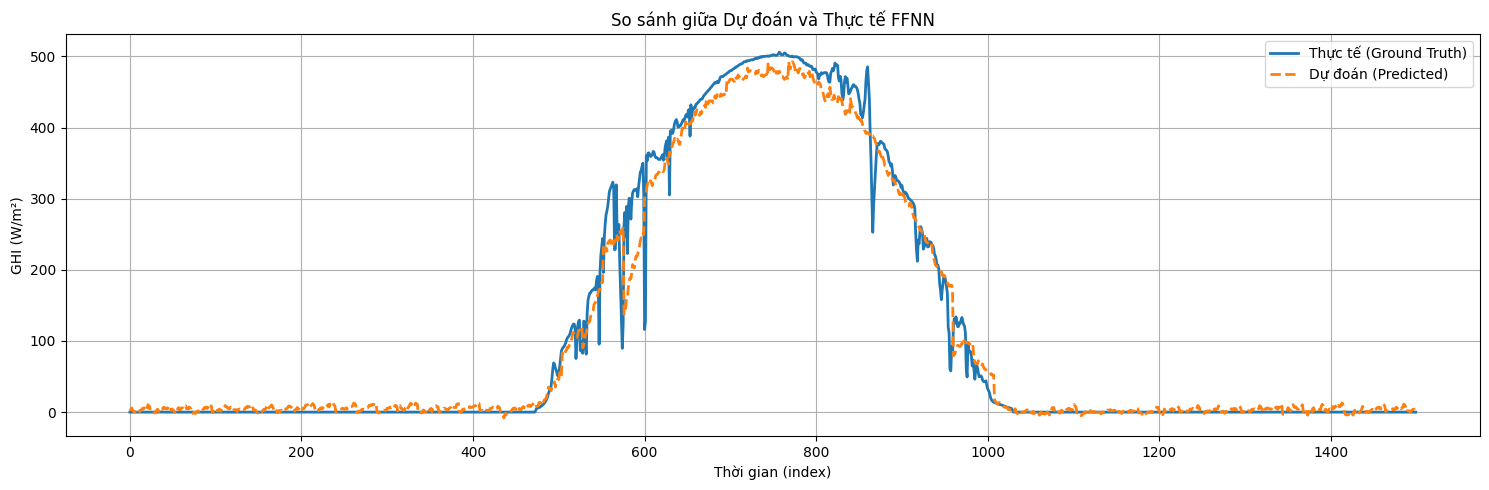

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(all_targets[:1500], label='Thực tế (Ground Truth)', linewidth=2)
plt.plot(all_scores[:1500], label='Dự đoán (Predicted)', linewidth=2, linestyle='--')

plt.title('So sánh giữa Dự đoán và Thực tế FFNN')
plt.xlabel('Thời gian (index)')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
from torchinfo import summary

model = RNN(input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            seq_length=sequence_length).to(device)

summary(model, input_size=(16, 24, 8))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [16, 24]                  --
├─RNN: 1-1                               [16, 24, 64]              13,056
├─Linear: 1-2                            [16, 24]                  36,888
Total params: 49,944
Trainable params: 49,944
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 5.60
Input size (MB): 0.01
Forward/backward pass size (MB): 0.20
Params size (MB): 0.20
Estimated Total Size (MB): 0.41